# Clustering scRNA Denoised Data

In [4]:
import pandas as pd
import scanpy as sc
import numpy as np

# plotting tools 
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# from scDMFK.io import Clustering
# computation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [5]:
def get_embedding(data):
    """ Function to compute the UMAP embedding"""
    data_scaled = StandardScaler().fit_transform(data)

    embedding = umap.UMAP(n_neighbors=10,
                            min_dist=0.5,
                            metric='correlation').fit_transform(data_scaled)
    return embedding


class Clustering():
    def __init__(self, adata, dataname, denoise_method, 
                label, transpose=False, random_seed=None, mode=['raw','denoise'],
                show_plot=False):
        self.adata = adata
        self.dataname = dataname
        self.denoise_method = denoise_method
        self.label = label
        self.transpose = transpose
        self.mode = mode
        self.random_seed = random_seed
        self.show_plot = show_plot
        self.n_clusters = len(np.unique(self.label))
        if not isinstance(self.random_seed, list):
            self.random_seed = [self.random_seed]
        
        self.datasets = []
        if 'raw' in self.mode:
            self.datasets.append(adata.raw.X.T if self.transpose else adata.raw.X) # raw data
        if 'denoise' in self.mode:
            self.datasets.append(adata.X.T
                                if self.transpose else adata.X) # denoised data
        if 'latent' in self.mode:
            self.datasets.append(adata.obsm['X_hidden'].T if self.transpose else adata.obsm['X_hidden']) # latent repre
        
        result = []
        self.embeddings = []
        self.fignames = []
        for mode, data in zip(self.mode, self.datasets):
            for seed in self.random_seed:
            
                print("seed: %d  Evaluating clustering results for %s data..." % (seed, mode))
                
                ari, nmi, sc, embedding = self.calculate_cluster_results(data, mode, seed)
                result.append([self.dataname, self.denoise_method, mode, seed, ari, nmi, sc])
                figname = '-'.join(str(s).lower() for s in [self.denoise_method, mode, seed]) + '.png'
                self.fignames.append(figname)
                self.embeddings.append(embedding)
                
        self.output = np.array(result)
        self.output = pd.DataFrame(self.output, 
                            columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
    
    def get_output(self):
        return self.output
    
    def get_umap(self,method=None, mode=None, seed=None, same_figure=False, output_dir=None,labelsize=15):
        search = lambda string, key: True if string is None else any([str(s) in key for s in string])
        inds = [
            (search(method, name) and search(mode, name) and search(seed, name)) for name in self.fignames]
        from itertools import compress
        
        embeddings = list(compress(self.embeddings, inds))
        fignames = list(compress(self.fignames,inds))
        
        if same_figure:
            self.draw_multiple_umap(embeddings, fignames, output_dir,labelsize=labelsize)
        else:
            for figname, emb in zip(fignames, embeddings):
                self.draw_umap(emb, figname, output_dir,labelsize=labelsize)
            
            
    def calculate_cluster_results(self, data, name, seed):
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        
        if seed is not None:
            np.random.seed(seed) #set random seed for reproducible results

        # get UMAP 2-D embedding
        embedding = get_embedding(data)
        # K-means for clustering umi embedings
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10).fit(embedding)
        labels = kmeans.labels_

        # Calculate metrics
        ari = adjusted_rand_score(self.label, labels)
        nmi = normalized_mutual_info_score(self.label, labels)
        sc = silhouette_score(embedding, labels)
        print(f'Adjusted Rand Index: {ari}')
        print(f'Normalized Mutual Information: {nmi}')
        print(f'Silhouette Coefficient: {sc}')
        
        return ari, nmi, sc, embedding

    def draw_umap(self, embedding, figname, output_dir=None, figsize=(15, 10), labelsize=15):  
        label = self.label

        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(figsize=figsize)

        plt.xlim([np.min(embedding[:, 0]) - 0.5, np.max(embedding[:, 0]) + 1.5])
        plt.ylim([np.min(embedding[:, 1]) - 0.5, np.max(embedding[:, 1]) + 0.5])
        plt.xlabel('UMAP 1', fontsize=labelsize)
        plt.ylabel('UMAP 2', fontsize=labelsize)
        plt.title(figname[:-4])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, 
                    hue_order=list(np.unique(label)), palette=palette)
        leg = plt.legend(prop={'size': labelsize}, loc=7, markerscale=2.00)
        leg.get_frame().set_alpha(0.9)
        plt.setp(ax, xticks=[], yticks=[])
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, figname))
    
    def draw_multiple_umap(self, embedding, names=None, output_dir=None, labelsize=15):
        label = self.label
    
        if not isinstance(embedding, list):
            embedding = [embedding]
        names = [names for i in range(len(embedding))] if names is None else [s[:-4] for s in names]
        
        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(1, len(embedding), figsize=(len(embedding)*12.5, 10))

        for (i, embed), figname in zip(enumerate(embedding), names):
            ax[i].set_xlim([np.min(embed[:, 0]) - 0.5, np.max(embed[:, 0]) + 1.5])
            ax[i].set_ylim([np.min(embed[:, 1]) - 0.5, np.max(embed[:, 1]) + 0.5])
            ax[i].set_xlabel('UMAP 1', fontsize=labelsize)
            ax[i].set_ylabel('UMAP 2', fontsize=labelsize)
            ax[i].set_title(figname)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            
            sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=label, 
                        hue_order=list(np.unique(label)), palette=palette, ax=ax[i])
            ax[i].get_legend().remove()
            plt.setp(ax[i], xticks=[], yticks=[])
            
        leg = fig.legend(*ax[0].get_legend_handles_labels(), 
                        prop={'size': labelsize}, loc=7, markerscale=2.00)
        leg.get_frame().set_alpha(0.9)
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, self.denoise_method+'-results.png'))

## 0. Simulation data

In [93]:
def load_simulate(data, show_result=True):
    # data
    truecounts = pd.read_csv('data/' + data + '/info_truecounts.tsv', sep='\t',index_col=0).T
    counts = pd.read_csv('data/' + data + '/counts.tsv', sep='\t',index_col=0).T
    dropout = pd.read_csv('data/' + data + '/info_dropout.tsv', sep='\t').T
    cellinfo = pd.read_csv('data/' + data + '/info_cellinfo.tsv', sep='\t')
    geneinfo = pd.read_csv('data/' + data + '/info_geneinfo.tsv', sep='\t')

    sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
    sim_raw.obs_names = cellinfo.Cell
    sim_raw.var_names = geneinfo.Gene
    sc.pp.filter_genes(sim_raw, min_counts=1)

    # remove zero-genes from dropout data frame too
    dropout_gt = dropout.loc[:, sim_raw.var_names].values

    sim_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
    sim_true.obs_names = cellinfo.Cell
    sim_true.var_names = geneinfo.Gene
    sim_true = sim_true[:, sim_raw.var_names].copy()

    sim_raw_norm = sim_raw.copy()
    sc.pp.filter_genes(sim_raw, min_counts=1)
    sc.pp.normalize_total(sim_raw_norm)
    sc.pp.log1p(sim_raw_norm)
    sc.pp.pca(sim_raw_norm)

    sim_true_norm = sim_true.copy()
    sc.pp.normalize_total(sim_true_norm)
    sc.pp.log1p(sim_true_norm)
    sc.pp.pca(sim_true_norm)

    if show_result:
        print(dropout_gt[:10, :10])
        print(sim_raw)
        print(sim_true)
    return sim_true, sim_true_norm, sim_raw, sim_raw_norm

In [100]:
######### dropout = 1 ##########
# data = 'group2_dropout1'
# sim1_true, sim1_true_norm, sim1_raw, sim1_raw_norm = load_simulate(data,show_result=False)

# sim1_label = pd.read_csv('data/' + data + '/info_cellinfo.tsv', sep='\t')['Group'].values
# sim1_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')
# sim1_zinb = sc.read('results/' + data + '/results-zinb.h5ad')
# sim1_wmse = sc.read('results/' + data + '/results-weight mse.h5ad')
# sim1_mmse = sc.read('results/' + data + '/results-mask mse.h5ad')

######### dropout = 5 ##########
data = 'group2_dropout5'
sim5_true, sim5_true_norm, sim5_raw, sim5_raw_norm = load_simulate(data,show_result=False)
sim5_label = pd.read_csv('data/' + data + '/info_cellinfo.tsv', sep='\t')['Group'].values # labels
cellinfo = pd.read_csv('data/' + data + '/info_cellinfo.tsv', sep='\t')
geneinfo = pd.read_csv('data/' + data + '/info_geneinfo.tsv', sep='\t')
## true counts
sim5_true.raw = sim5_raw
## scdm
sim5_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')
sim5_zinb = sc.read('results/' + data + '/results-zinb.h5ad')
sim5_wmse = sc.read('results/' + data + '/results-weight mse.h5ad')
sim5_mmse = sc.read('results/' + data + '/results-mask mse.h5ad')
## dca
sim5_dca = pd.read_csv('results/' + data + '/mean.tsv', sep='\t', index_col=0).T
sim5_dca = sc.AnnData(sim5_dca, obs=cellinfo, var=geneinfo)
sim5_dca.raw = sim5_raw
## averaging 
sim5_mean = pd.read_csv('results/' + data + '/mean_replaced.csv', index_col=0).T
sim5_mean = sc.AnnData(sim5_mean, obs=cellinfo, var=geneinfo)
sim5_mean.raw = sim5_raw

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yufeideng/Doc

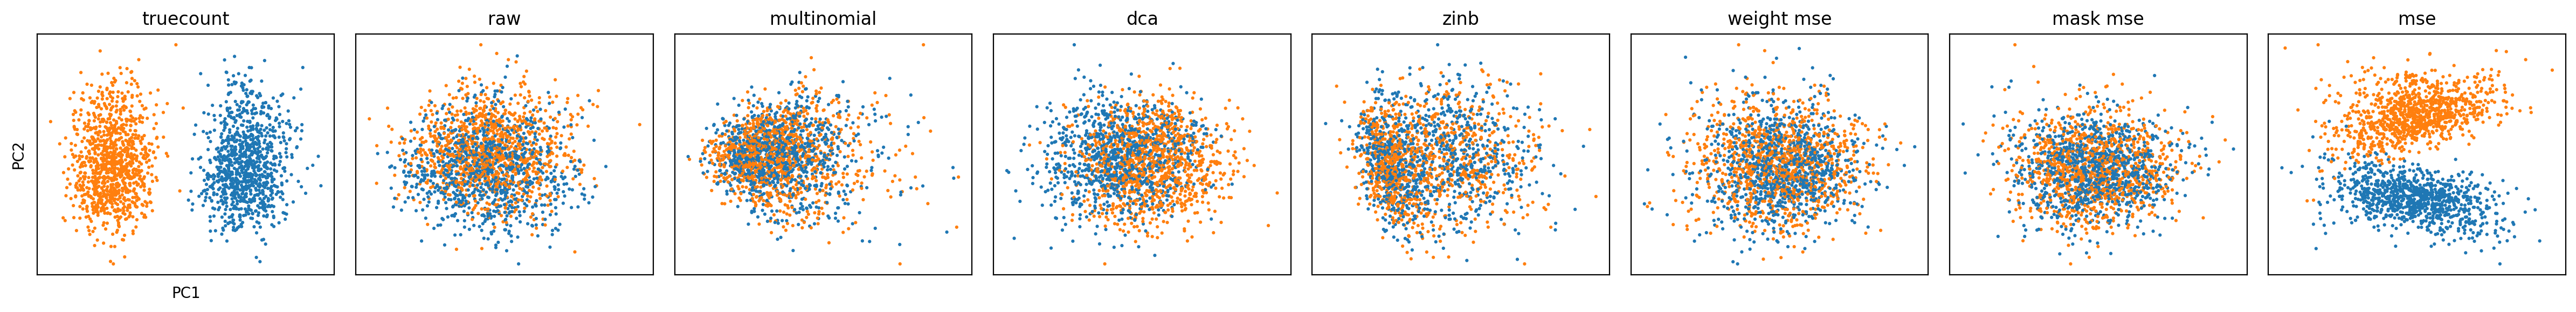

In [127]:
denoise_data = [sim5_true, sim5_raw, sim5_multinom, sim5_dca, sim5_zinb, sim5_wmse, sim5_mmse, sim5_mean]
denoise_methods = ['truecount','raw', 'multinomial','dca','zinb', 'weight mse','mask mse','mse']
adatas = []

for (adata, dn_method) in zip(denoise_data, denoise_methods):
    
    adata.obs=cellinfo
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm)
    sc.pp.log1p(adata_norm)
    sc.pp.pca(adata_norm)
    adatas.append(adata_norm)
# adatas = [sim1_true_norm, sim1_raw_norm, dca1_conddisp_norm, dca1_zinb_norm, dca1_mse_norm]
# adata_labels = ['Without\ndropout', 'With\ndropout','Denoised\n(NB cond)', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas), figsize=(3*len(adatas),3))

for i, (lbl, ad, ax) in enumerate(zip(denoise_methods, adatas, axs)):
    sc.pl.pca_scatter(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()
#plt.savefig('two-group-pca.pdf')

In [ ]:
sim5_zinb = Clustering(adata=df_dn, dataname=data,label=sim5_label, 
                        denoise_method=dn_method, 
                        random_seed=random_seed[:2], mode=mode)
        

In [129]:
denoise_data = [sim5_true, sim5_multinom, sim5_dca, sim5_zinb, sim5_wmse, sim5_mmse, sim5_mean]
denoise_methods = ['truecount', 'multinomial','dca','zinb', 'weight mse','mask mse','mse']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

sim_cluster_result = pd.DataFrame(columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
for i, dn_method in enumerate(denoise_methods):
    for df_dn in denoise_data:
        mode = ['denoise'] if i!=0 else ['raw', 'denoise']

        cluster = Clustering(adata=df_dn, dataname=data,label=sim5_label, 
                        denoise_method=dn_method, 
                        random_seed=random_seed[:2], mode=mode)
        
        result = cluster.get_output()
        sim_cluster_result = pd.concat([sim_cluster_result, result])

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.0007252656786956404
Normalized Mutual Information: 0.0008180778248429382
Silhouette Coefficient: 0.3395675718784332
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.9920120059962769
Normalized Mutual Information: 0.9791787476409122
Silhouette Coefficient: 0.5510164499282837
seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.0006563361418235074
Normalized Mutual Information: 0.000818021993900975
Silhouette Coefficient: 0.33876585960388184
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: -0.0003563935901909015
Normalized Mutual Information: 7.228679157498654e-05
Silhouette Coefficient: 0.5016060471534729
seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: -0.0004642420195499344
Normalized Mutual Information: 2.05540586953444e-05
Silhouette Coefficient: 0.3474840819835663
seed: 1111  

In [130]:
sim_cluster_result

data denoise method     mode random seed  \
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5      truecount      raw        1111   
1  group2_dropout5      truecount  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5    multinomial  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5            dca  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5           zinb  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5     weight mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5       mask mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   
0  group2_dropout5            mse  denoise        1111   

                       ARI                     NMI          SC  
0    0.0007252656786956404   0.0008180778248429382  0.33956757  
1       0.9920120059962769      0.9791787476409122  0.55101645  
0    0.0006563361418235074    0.000818021993900975  0.33876586  
1   -0.0003563935901909015   7.228679157498654e-05  0.50160605  
0   -0.0004642420195499344    2.05540586953444e-05  0.34748408  
1  -1.6047164780770708e-05   0.0003194953646988819  0.44338727  
0   2.8999296487336524e-05  0.00040731364884641537  0.35305938  
1  -0.00043621198125908266   5.084666755862973e-05  0.45045647  
0    0.0031015374345146098   0.0025420046847340052  0.34553772  
1  -0.00047529001205482406  2.6980869644311708e-05   0.51

## 1. Endoderm Cells

### scDMFK methods

In [175]:
dataset = 'endoderm'
# true labels
end_label = pd.read_csv('data/'+dataset+'/cell_label.csv').label 

# endoderm subsets
num_genes = [500,1000,5000,10000]
data_folders = [dataset] + [dataset + '-%s'%n_genes for n_genes in num_genes]
denoise_methods = ['multinomial', 'zinb', 'weight mse','mask mse']
mode = ['raw', 'denoise']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

cluster_result = pd.DataFrame(columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
for dn_method in denoise_methods:
    for data in data_folders:
        df_dn = sc.read('results/' + data + '/results-%s.h5ad' %dn_method )
        cluster = Clustering(adata=df_dn, dataname=data,label=end_label, 
                        denoise_method=dn_method, 
                        random_seed=random_seed[:5], mode=mode)

        result = cluster.get_output()
        cluster_result= pd.concat([cluster_result, result])

# cluster_result.to_csv('results/endoderm_cluster_results.csv', index=False)


seed: 1111  Evaluating clustering results for raw data...


Adjusted Rand Index: 0.6055332178891343
Normalized Mutual Information: 0.7567677265714411
Silhouette Coefficient: 0.5553233623504639
seed: 2222  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.5951712417227256
Normalized Mutual Information: 0.7484081465703816
Silhouette Coefficient: 0.5617596507072449
seed: 3333  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6048385393125677
Normalized Mutual Information: 0.7460285362131035
Silhouette Coefficient: 0.5596623420715332
seed: 4444  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6186017168135023
Normalized Mutual Information: 0.7586061182165209
Silhouette Coefficient: 0.5447055697441101
seed: 5555  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6313422750791814
Normalized Mutual Information: 0.7604157377582147
Silhouette Coefficient: 0.5583828687667847
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.7946826677325431
N

data denoise method  ...                 NMI          SC
0         endoderm    multinomial  ...  0.7567677265714411  0.55532336
1         endoderm    multinomial  ...  0.7484081465703816  0.56175965
2         endoderm    multinomial  ...  0.7460285362131035  0.55966234
3         endoderm    multinomial  ...  0.7586061182165209  0.54470557
4         endoderm    multinomial  ...  0.7604157377582147  0.55838287
..             ...            ...  ...                 ...         ...
5   endoderm-10000       mask mse  ...  0.6718777538066518  0.47468743
6   endoderm-10000       mask mse  ...  0.7057368695220657  0.48049527
7   endoderm-10000       mask mse  ...  0.6989878978298708  0.52947843
8   endoderm-10000       mask mse  ...  0.7072670470121836  0.48261154
9   endoderm-10000       mask mse  ...  0.6912371945717742  0.48933807

[200 rows x 7 columns]

### Methods for Comparison

In [30]:
############ DCA ############
end_raw = pd.read_csv('data/endoderm/endoderm.csv', index_col=0).T
end_raw = sc.AnnData(end_raw)
end_dca = pd.read_csv('results/endoderm/mean.tsv', sep='\t', index_col=0).T
end_dca = sc.AnnData(end_dca)

end_dca.raw = end_raw
dca_zinb = Clustering(adata=end_dca, dataname='endoderm', denoise_method='dca zinb', 
                    label=end_label, random_seed=random_seed[:5], mode=['denoise'])
dca_zinb.get_output()

######### Averaging ############
end_mean = pd.read_csv('results/endoderm/endoderm_mean_replaced.csv', index_col=0).T
end_mean = sc.AnnData(end_mean)
end_mean.raw = end_raw
mse_mean = Clustering(adata=end_mean, dataname='endoderm', denoise_method='mse',
                    label=end_label, random_seed=random_seed[:5], mode=['denoise'])
mse_mean.get_output()

seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5807705381197978
Normalized Mutual Information: 0.720975056653486
Silhouette Coefficient: 0.5303240418434143
seed: 2222  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5345547794830334
Normalized Mutual Information: 0.6842791830794898
Silhouette Coefficient: 0.5347416400909424
seed: 3333  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5573661974168402
Normalized Mutual Information: 0.7130326408636992
Silhouette Coefficient: 0.5477644801139832
seed: 4444  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5699413631067642
Normalized Mutual Information: 0.7160419275043672
Silhouette Coefficient: 0.5425493121147156
seed: 5555  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5657702234303132
Normalized Mutual Information: 0.713012925408733
Silhouette Coefficient: 0.541447103023529


data denoise method     mode random seed                 ARI  \
0  edoderm            mse  denoise        1111  0.5807705381197978   
1  edoderm            mse  denoise        2222  0.5345547794830334   
2  edoderm            mse  denoise        3333  0.5573661974168402   
3  edoderm            mse  denoise        4444  0.5699413631067642   
4  edoderm            mse  denoise        5555  0.5657702234303132   

                  NMI          SC  
0   0.720975056653486  0.53032404  
1  0.6842791830794898  0.53474164  
2  0.7130326408636992   0.5477645  
3  0.7160419275043672   0.5425493  
4   0.713012925408733   0.5414471

In [90]:
dca_result = dca_zinb.get_output().drop(columns='mode')
mse_result = mse_mean.get_output().drop(columns='mode')
dca_result['random seed'] = dca_result['random seed'].astype(str)
mse_result['random seed'] = mse_result['random seed'].astype(str)
dca_result[['ARI','NMI','SC']] = dca_result[['ARI','NMI','SC']].astype('float32')
mse_result[['ARI','NMI','SC']] = mse_result[['ARI','NMI','SC']].astype('float32')


In [92]:
dataset='endoderm'
num_genes = [500,1000,5000,10000]
datanames = ['endoderm-%s'%n_genes for n_genes in num_genes] + ['endoderm'] 

cluster_result[['ARI','NMI','SC']] = cluster_result[['ARI','NMI','SC']].astype('float32')
cluster_result['random seed'] = cluster_result['random seed'].astype(str)
raw = cluster_result[cluster_result['mode']=='raw'].drop(columns='denoise method').rename(columns={'mode':'denoise method'})
other = cluster_result[cluster_result['mode']!='raw'].drop(columns='mode')
cluster_result = pd.concat([raw, other])#.groupby(by=['data', 'denoise method']).mean().reset_index()
cluster_result = pd.concat([cluster_result, pd.concat([dca_result, mse_result])])
# cluster_result.to_csv('results/endoderm_cluster_results.csv', index=False)
cluster_result = cluster_result.groupby(by=['data', 'denoise method']).mean()
cluster_result = cluster_result.loc[datanames, ['raw','multinomial','dca zinb','zinb','weight mse','mask mse','mse'],:].reset_index()


###### Next time: ######
# cluster_result = pd.read_csv('results/endoderm_cluster_results.csv')


/var/folders/tz/17sr6ctn7t59v0xfhzjh4l380000gn/T/ipykernel_2494/1672042309.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['500','1000','5000','10000','endoderm'])
/var/folders/tz/17sr6ctn7t59v0xfhzjh4l380000gn/T/ipykernel_2494/1672042309.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['500','1000','5000','10000','endoderm'])
/var/folders/tz/17sr6ctn7t59v0xfhzjh4l380000gn/T/ipykernel_2494/1672042309.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['500','1000','5000','10000','endoderm'])


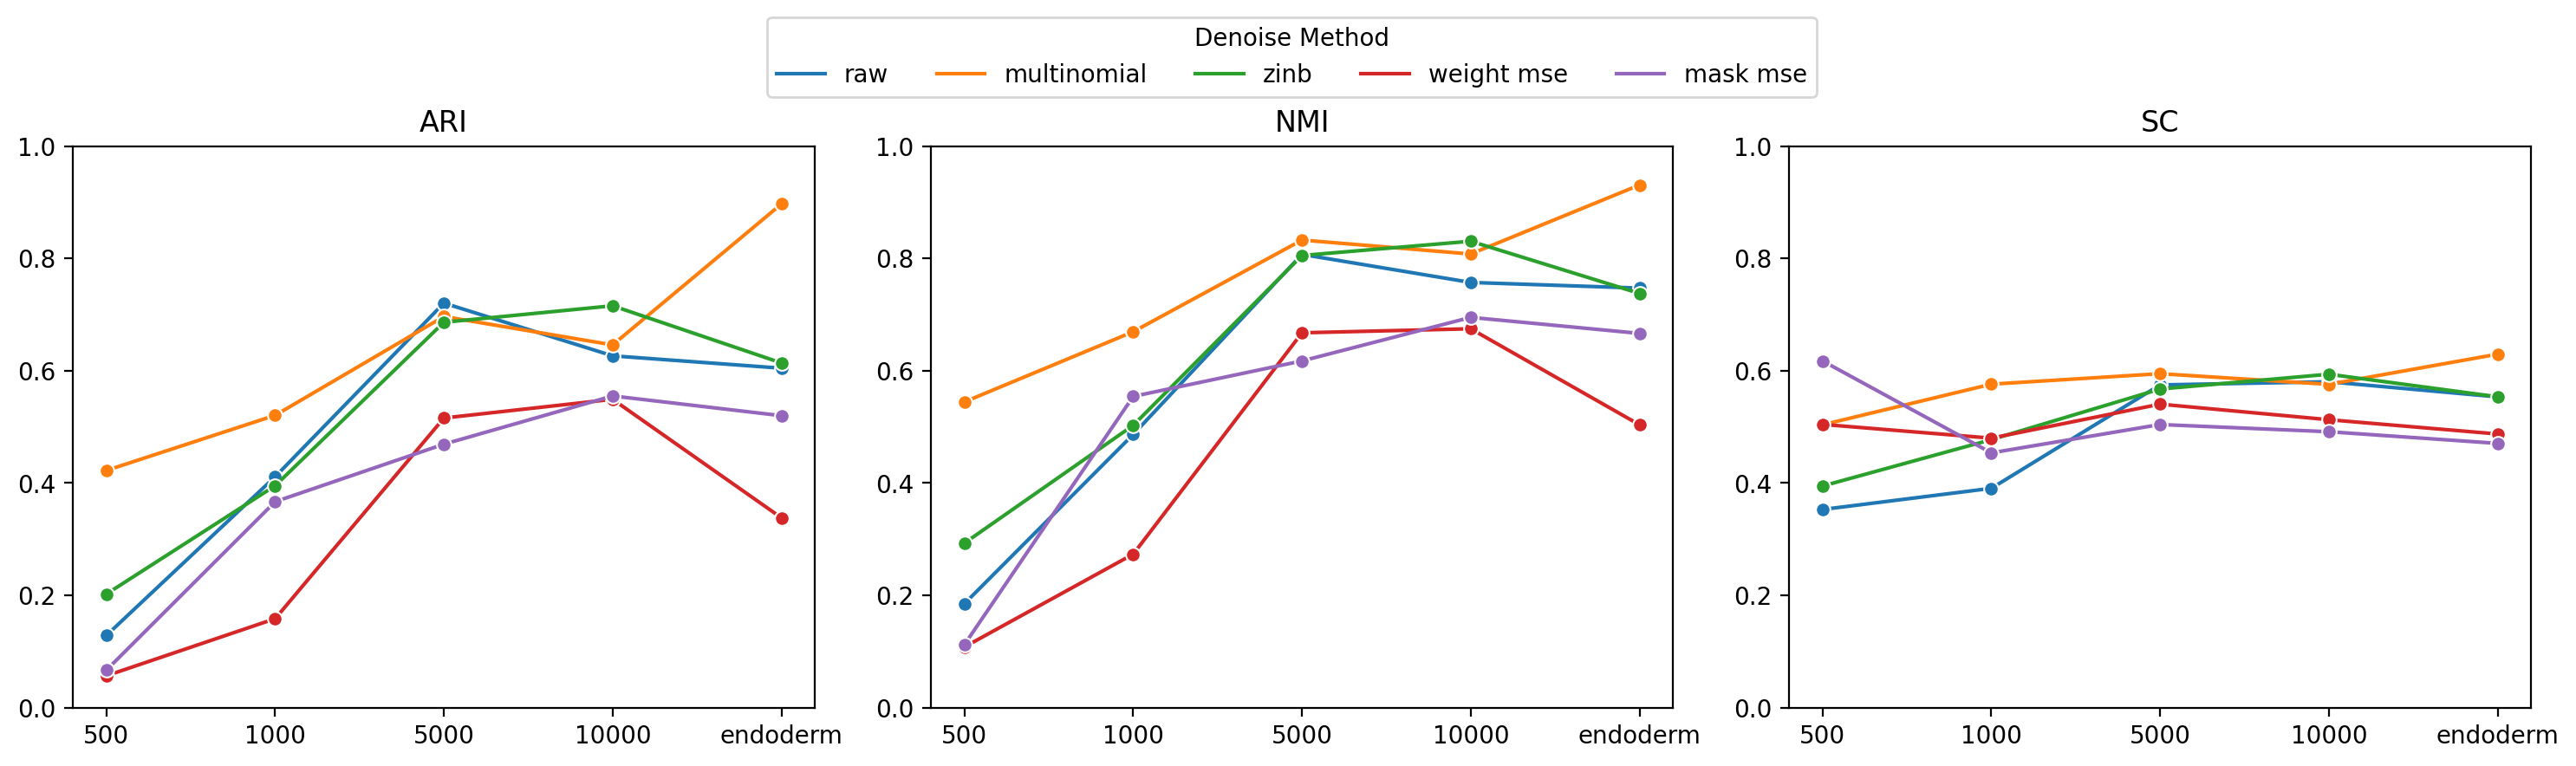

In [232]:
# We will create a line plot and a box plot for each metric (ARI, NMI, and SC)
# First, we'll prepare the data for plotting
scdm_result = cluster_result[
    [s in ['raw','multinomial','zinb','weight mse','mask mse'] for s in cluster_result['denoise method']]]
df_melted = scdm_result.melt(id_vars=['data', 'denoise method'], var_name='metric', value_name='value')

# Line plots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, (metric, ax) in enumerate(zip(['ARI', 'NMI', 'SC'], axs)):
    sns.lineplot(data=df_melted[df_melted['metric'] == metric], x='data', y='value', hue='denoise method', marker='o', ax=ax)
    ax.set_title(f'{metric}')
    ax.set_ylim(0,1.0)
    ax.xaxis.set_ticklabels(['500','1000','5000','10000','endoderm'])
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.legend(*axs[1].get_legend_handles_labels(), 
        title='Denoise Method', bbox_to_anchor=(0, 0.11, 1,1), loc='upper center',ncols=5)
plt.tight_layout()
plt.show()

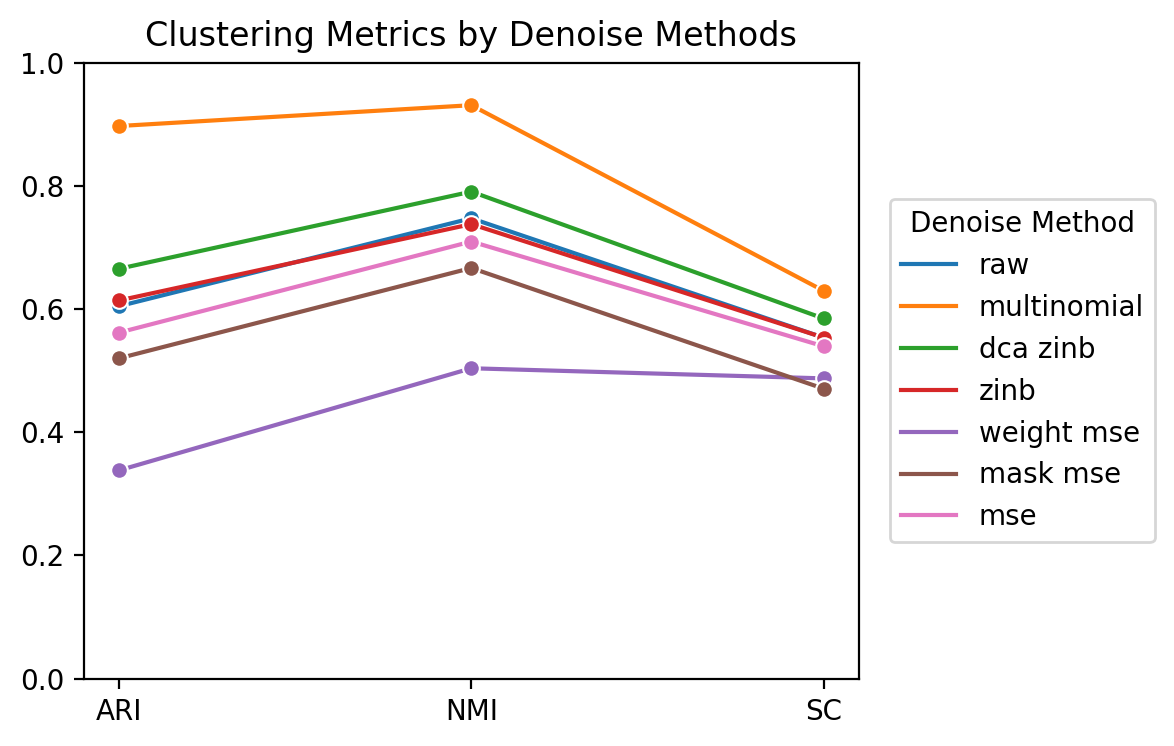

In [77]:
# We will create a line plot and a box plot for each metric (ARI, NMI, and SC)
# First, we'll prepare the data for plotting
endoderm_result = cluster_result[cluster_result['data']=='endoderm']
df_melted = endoderm_result.melt(id_vars=['data', 'denoise method'], var_name='metric', value_name='value')

# Line plots
fig, ax = plt.subplots(figsize=(5, 4))

# for i, (metric, ax) in enumerate(zip(['ARI', 'NMI', 'SC'], axs)):
sns.lineplot(data=df_melted, x='metric', y='value', hue='denoise method',marker='o', ax=ax)
ax.set_title('Clustering Metrics by Denoise Methods')
ax.set_ylim(0,1.0)
# ax.xaxis.set_ticklabels(['500','1000','5000','10000','endoderm'])
ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Denoise Method', bbox_to_anchor=(0.4,0.5,1,0), loc=7)
# plt.tight_layout()
plt.show()

### Eenendoderm: Examining each denoising result

### Full endoderm dataset

In [177]:
# full endoderm dataset
data = 'endoderm'
end_label = pd.read_csv('data/endoderm/cell_label.csv').label # true labels

end_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')
end_zinb = sc.read('results/' + data + '/results-zinb.h5ad')
end_wmse = sc.read('results/' + data + '/results-weight mse.h5ad')
end_mmse = sc.read('results/' + data + '/results-mask mse.h5ad')

In [239]:
zinb = Clustering(adata=end_zinb, dataname='endoderm', denoise_method='zinb', 
                    label=end_label, random_seed=1111, mode=['raw', 'denoise'])
multinom = Clustering(adata=end_multinom, dataname='endoderm', denoise_method='multinomial', 
                    label=end_label, random_seed=1111, mode=['raw','denoise'])
wmse = Clustering(adata=end_wmse, dataname='endoderm', denoise_method='weight mse', 
                    label=end_label, random_seed=1111, mode=['raw','denoise'])
mmse = Clustering(adata=end_mmse, dataname='endoderm', denoise_method='mask mse', 
                    label=end_label, random_seed=1111, mode=['raw','denoise'])

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6105597274475091
Normalized Mutual Information: 0.7480503224638321
Silhouette Coefficient: 0.5644100904464722
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.6270653401715774
Normalized Mutual Information: 0.7514944857461657
Silhouette Coefficient: 0.5717793703079224


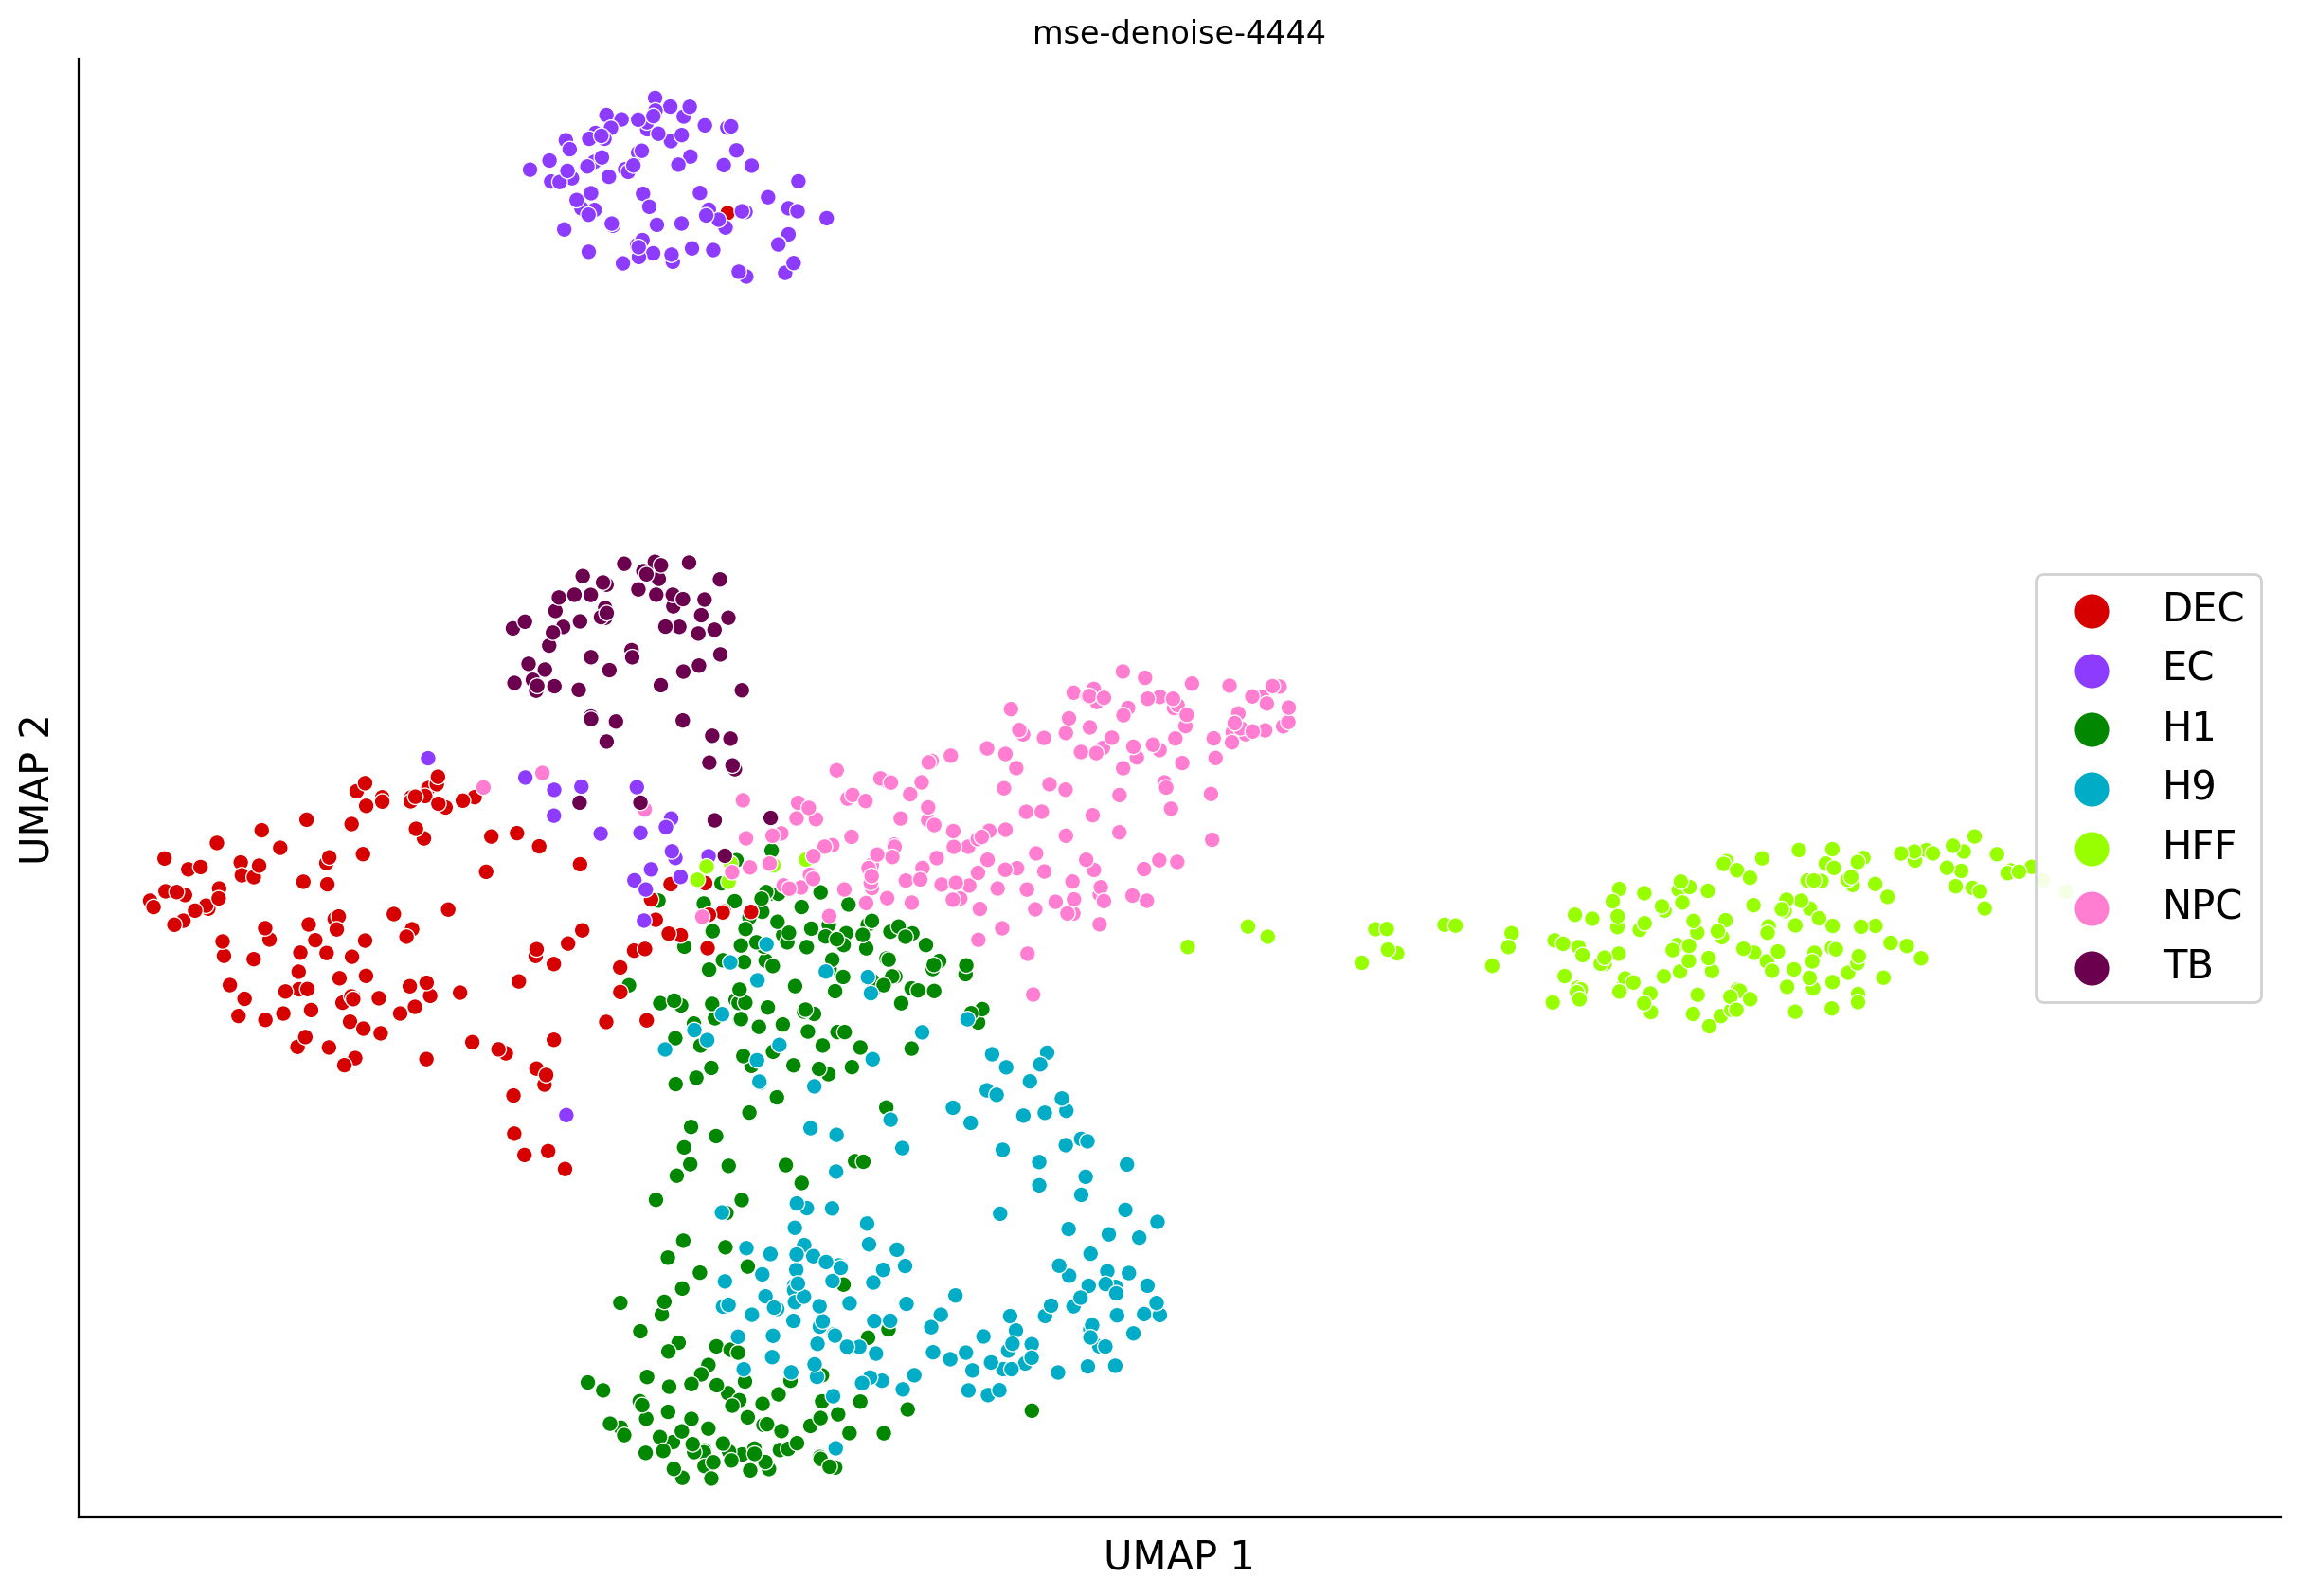

In [88]:
mse_mean.get_umap(seed='4444',output_dir=)

In [85]:
## baseline
mse.get_umap()

NameError: name 'mean_mse' is not defined

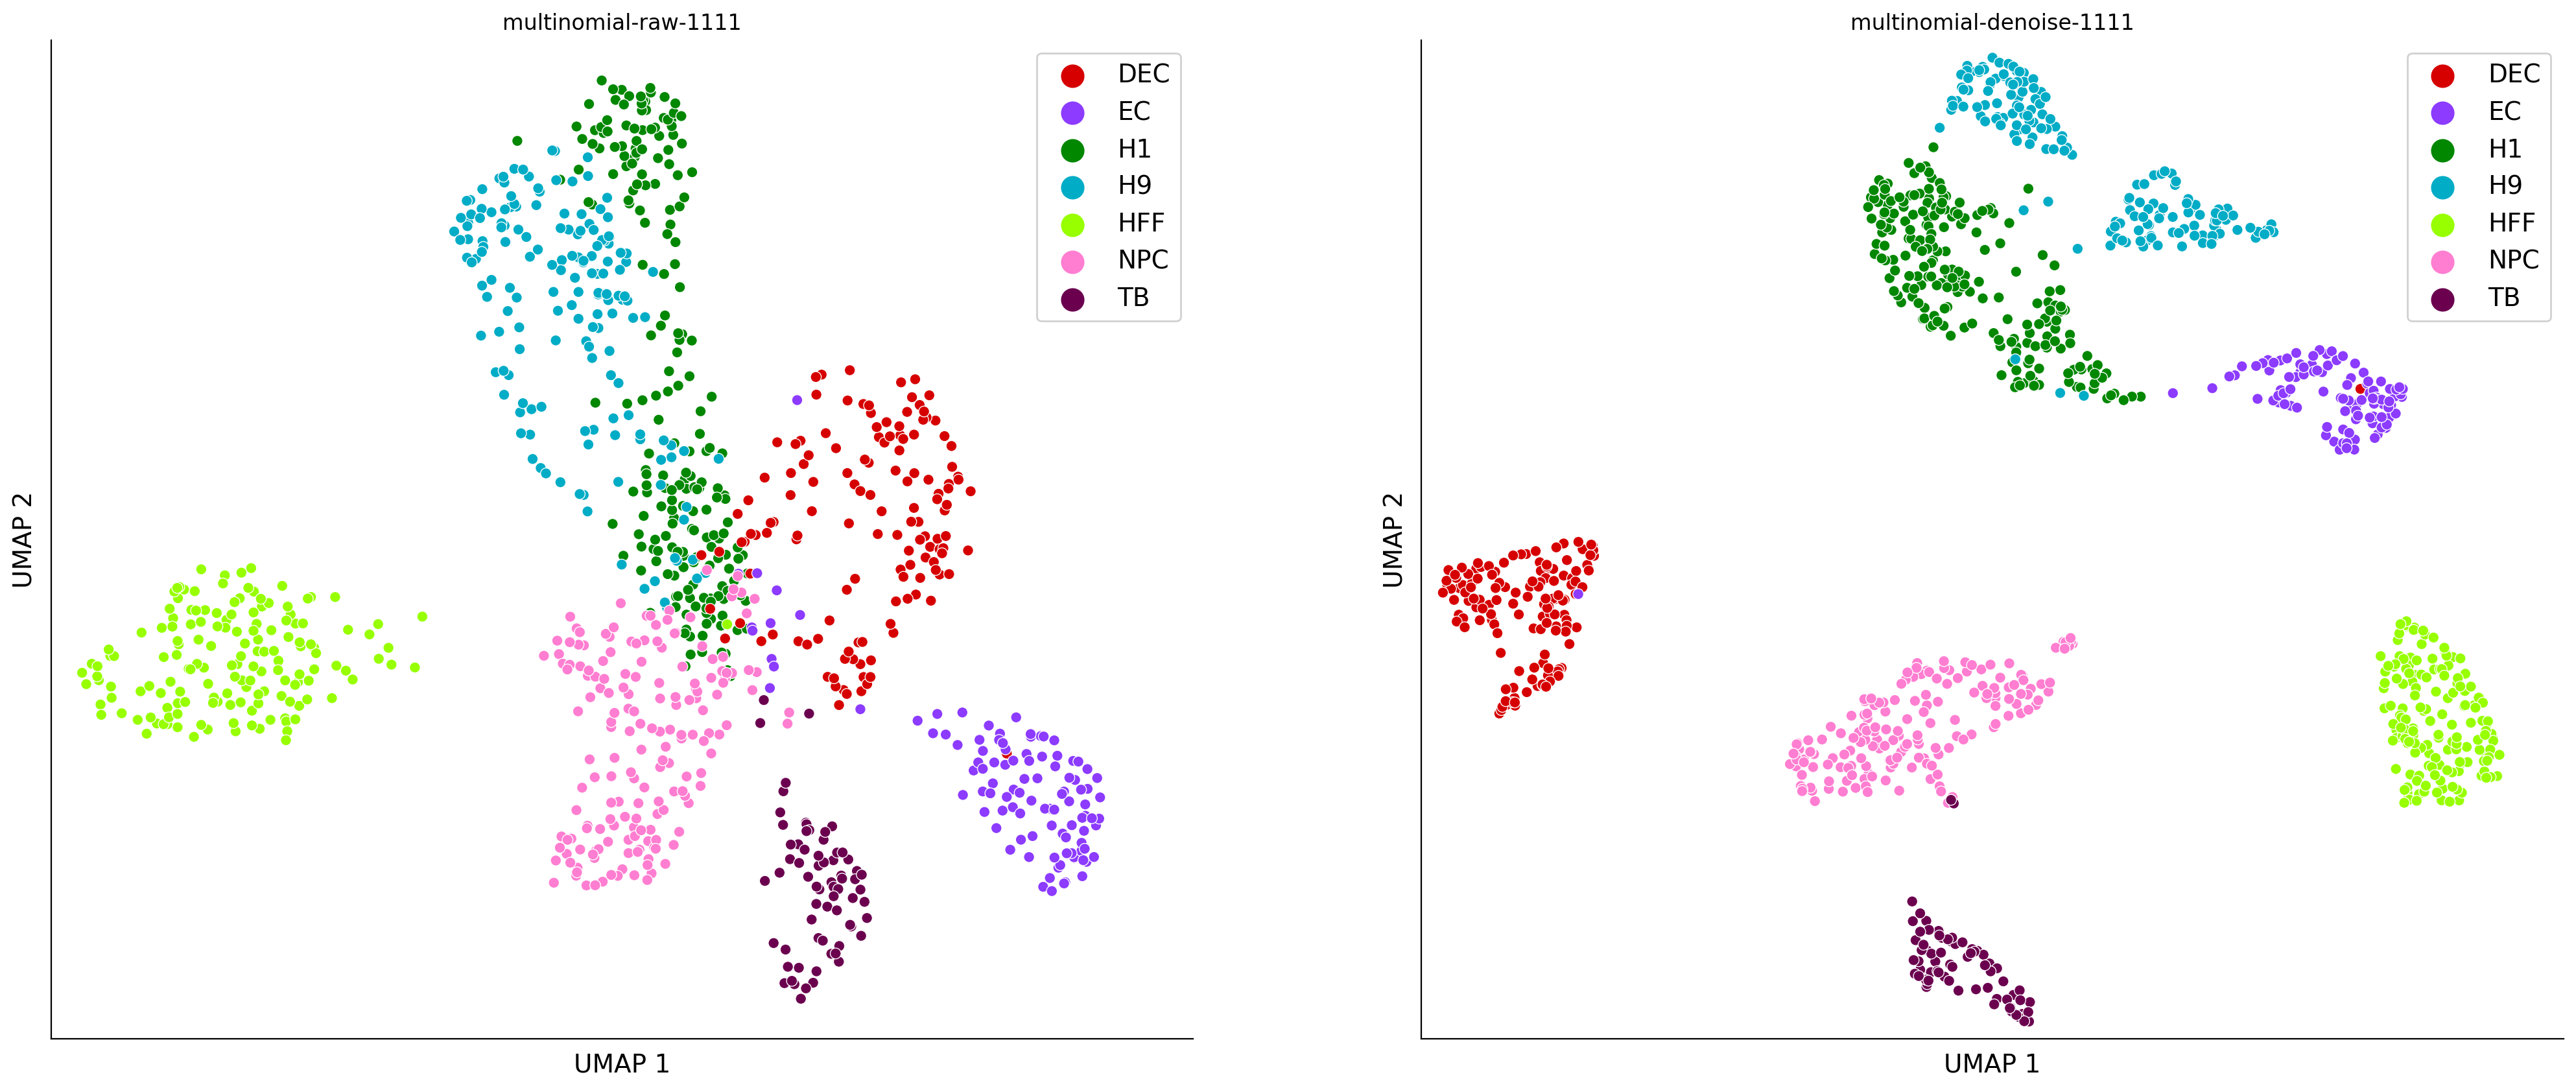

In [213]:
# multinomial
multinom.get_umap(same_figure=True)

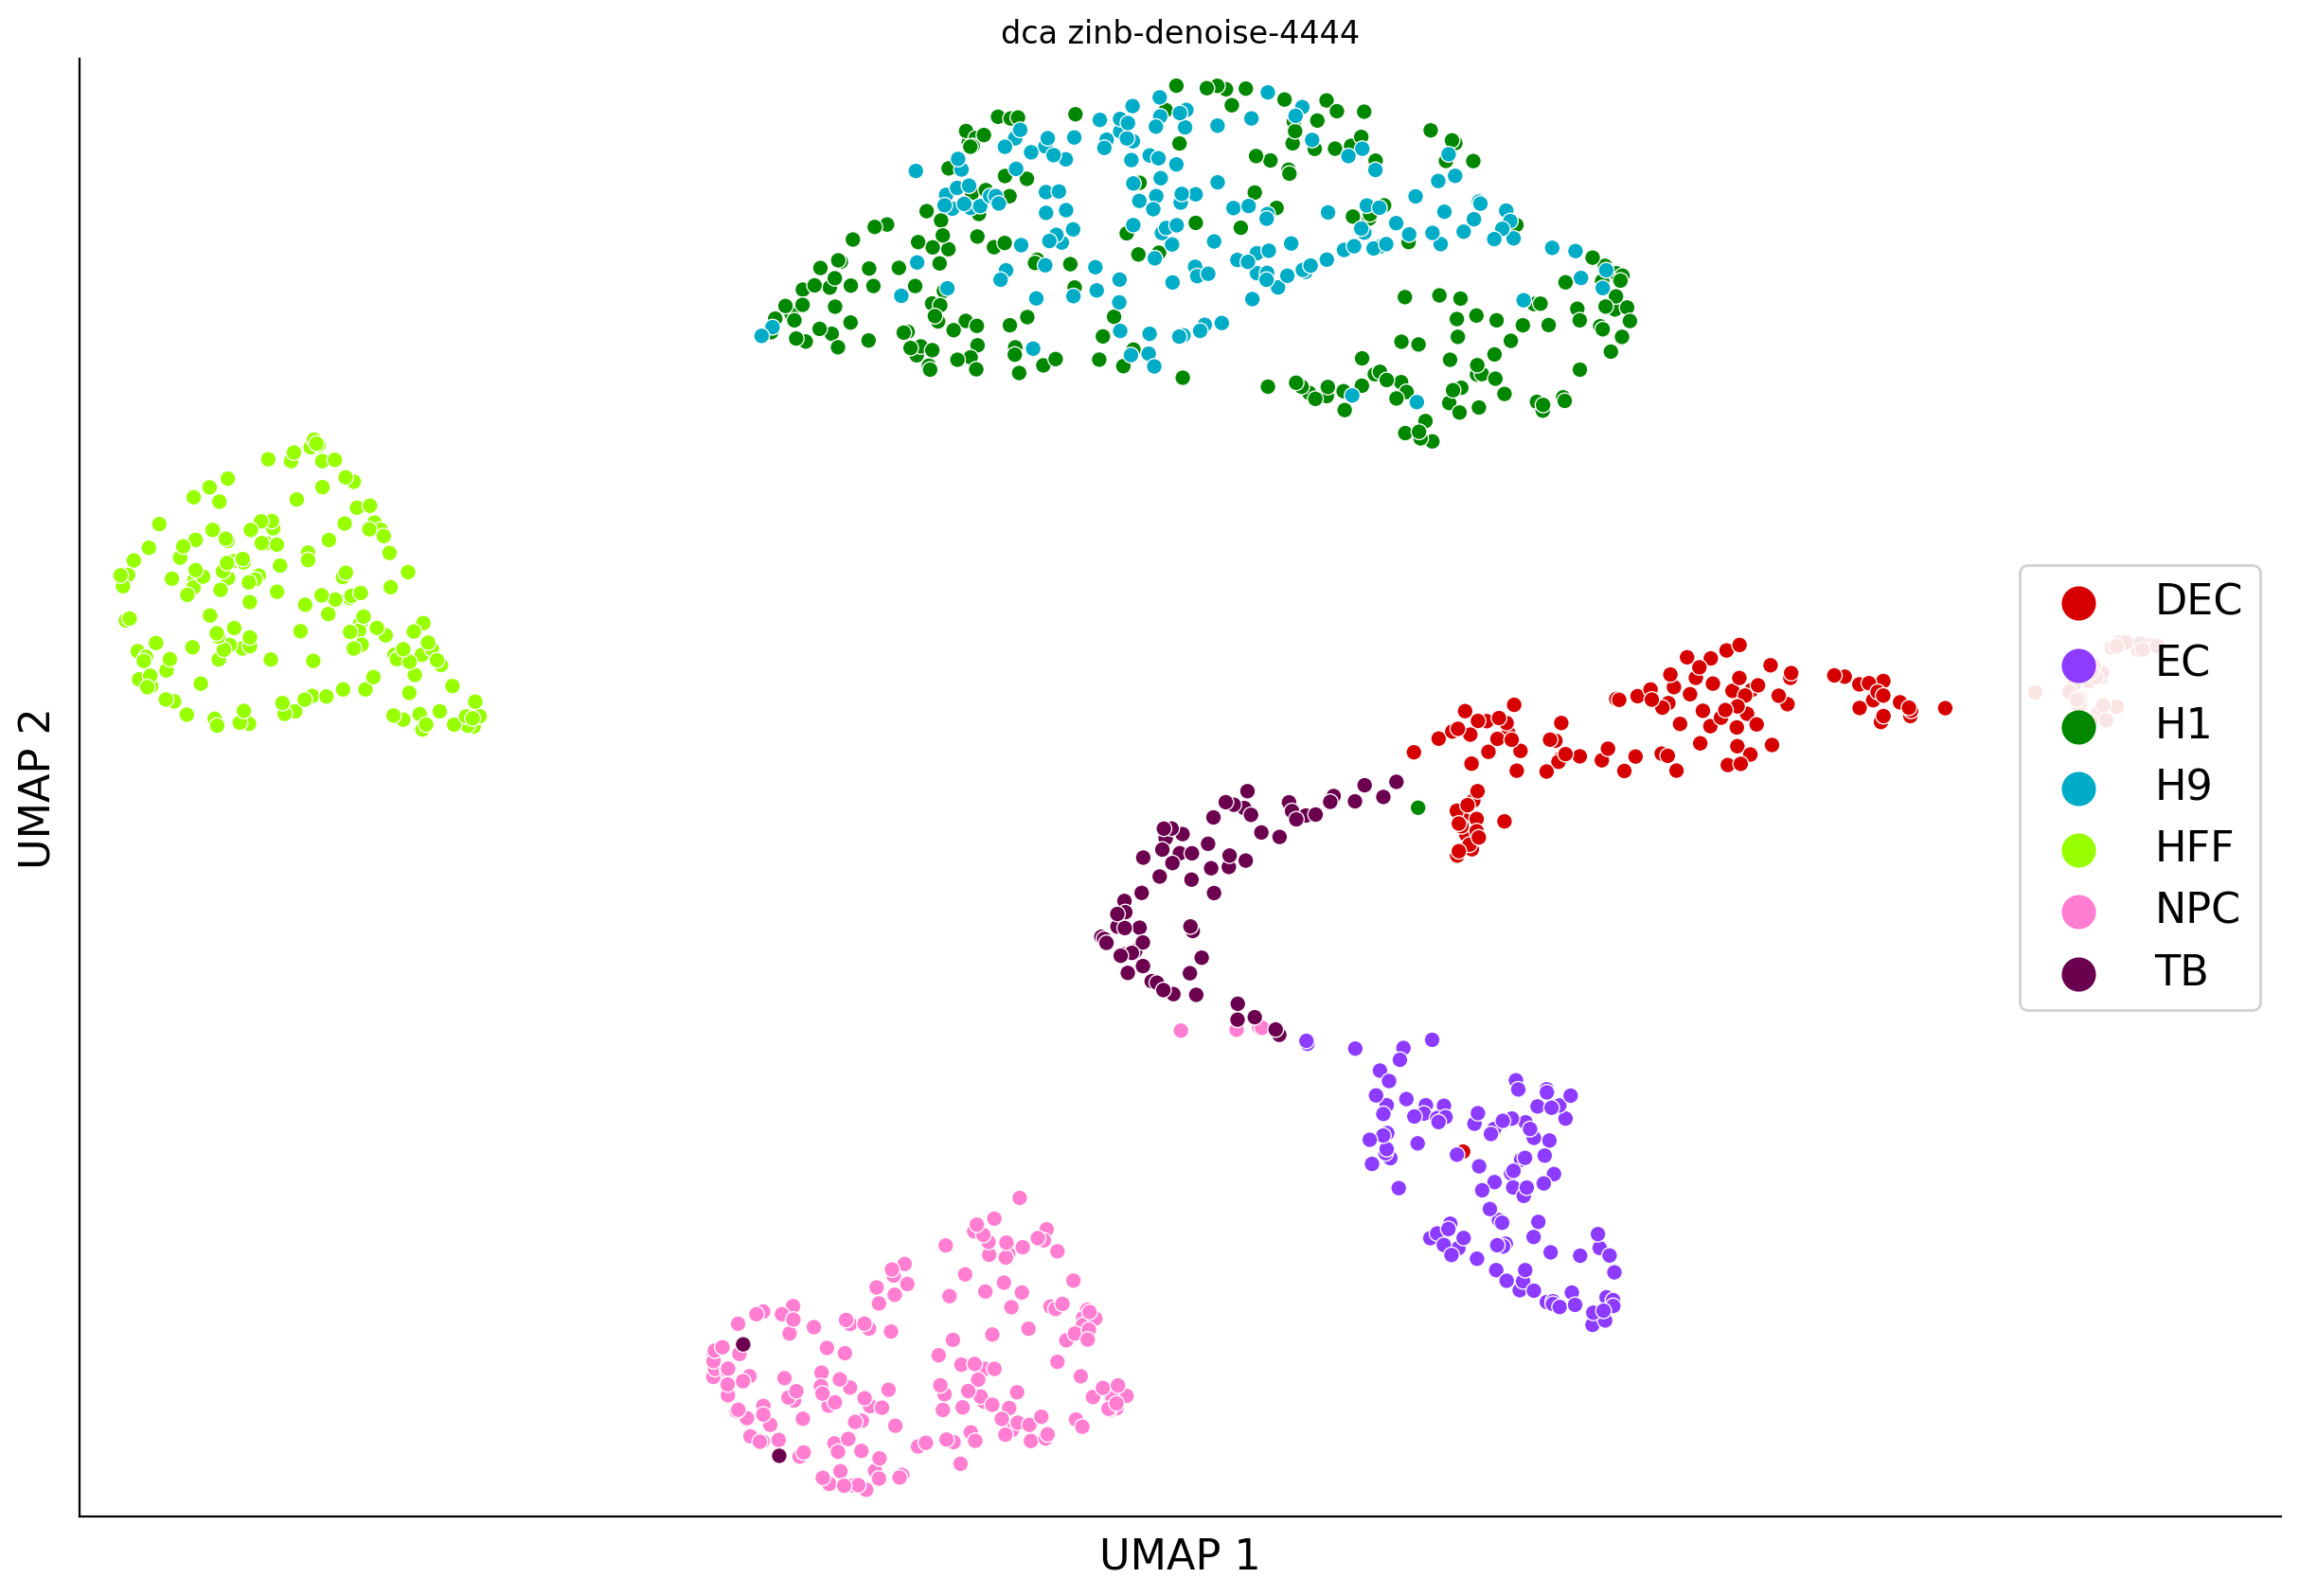

In [83]:
# dca zinb umap clustering results
dca_zinb.get_umap(seed='4444', labelsize=16)

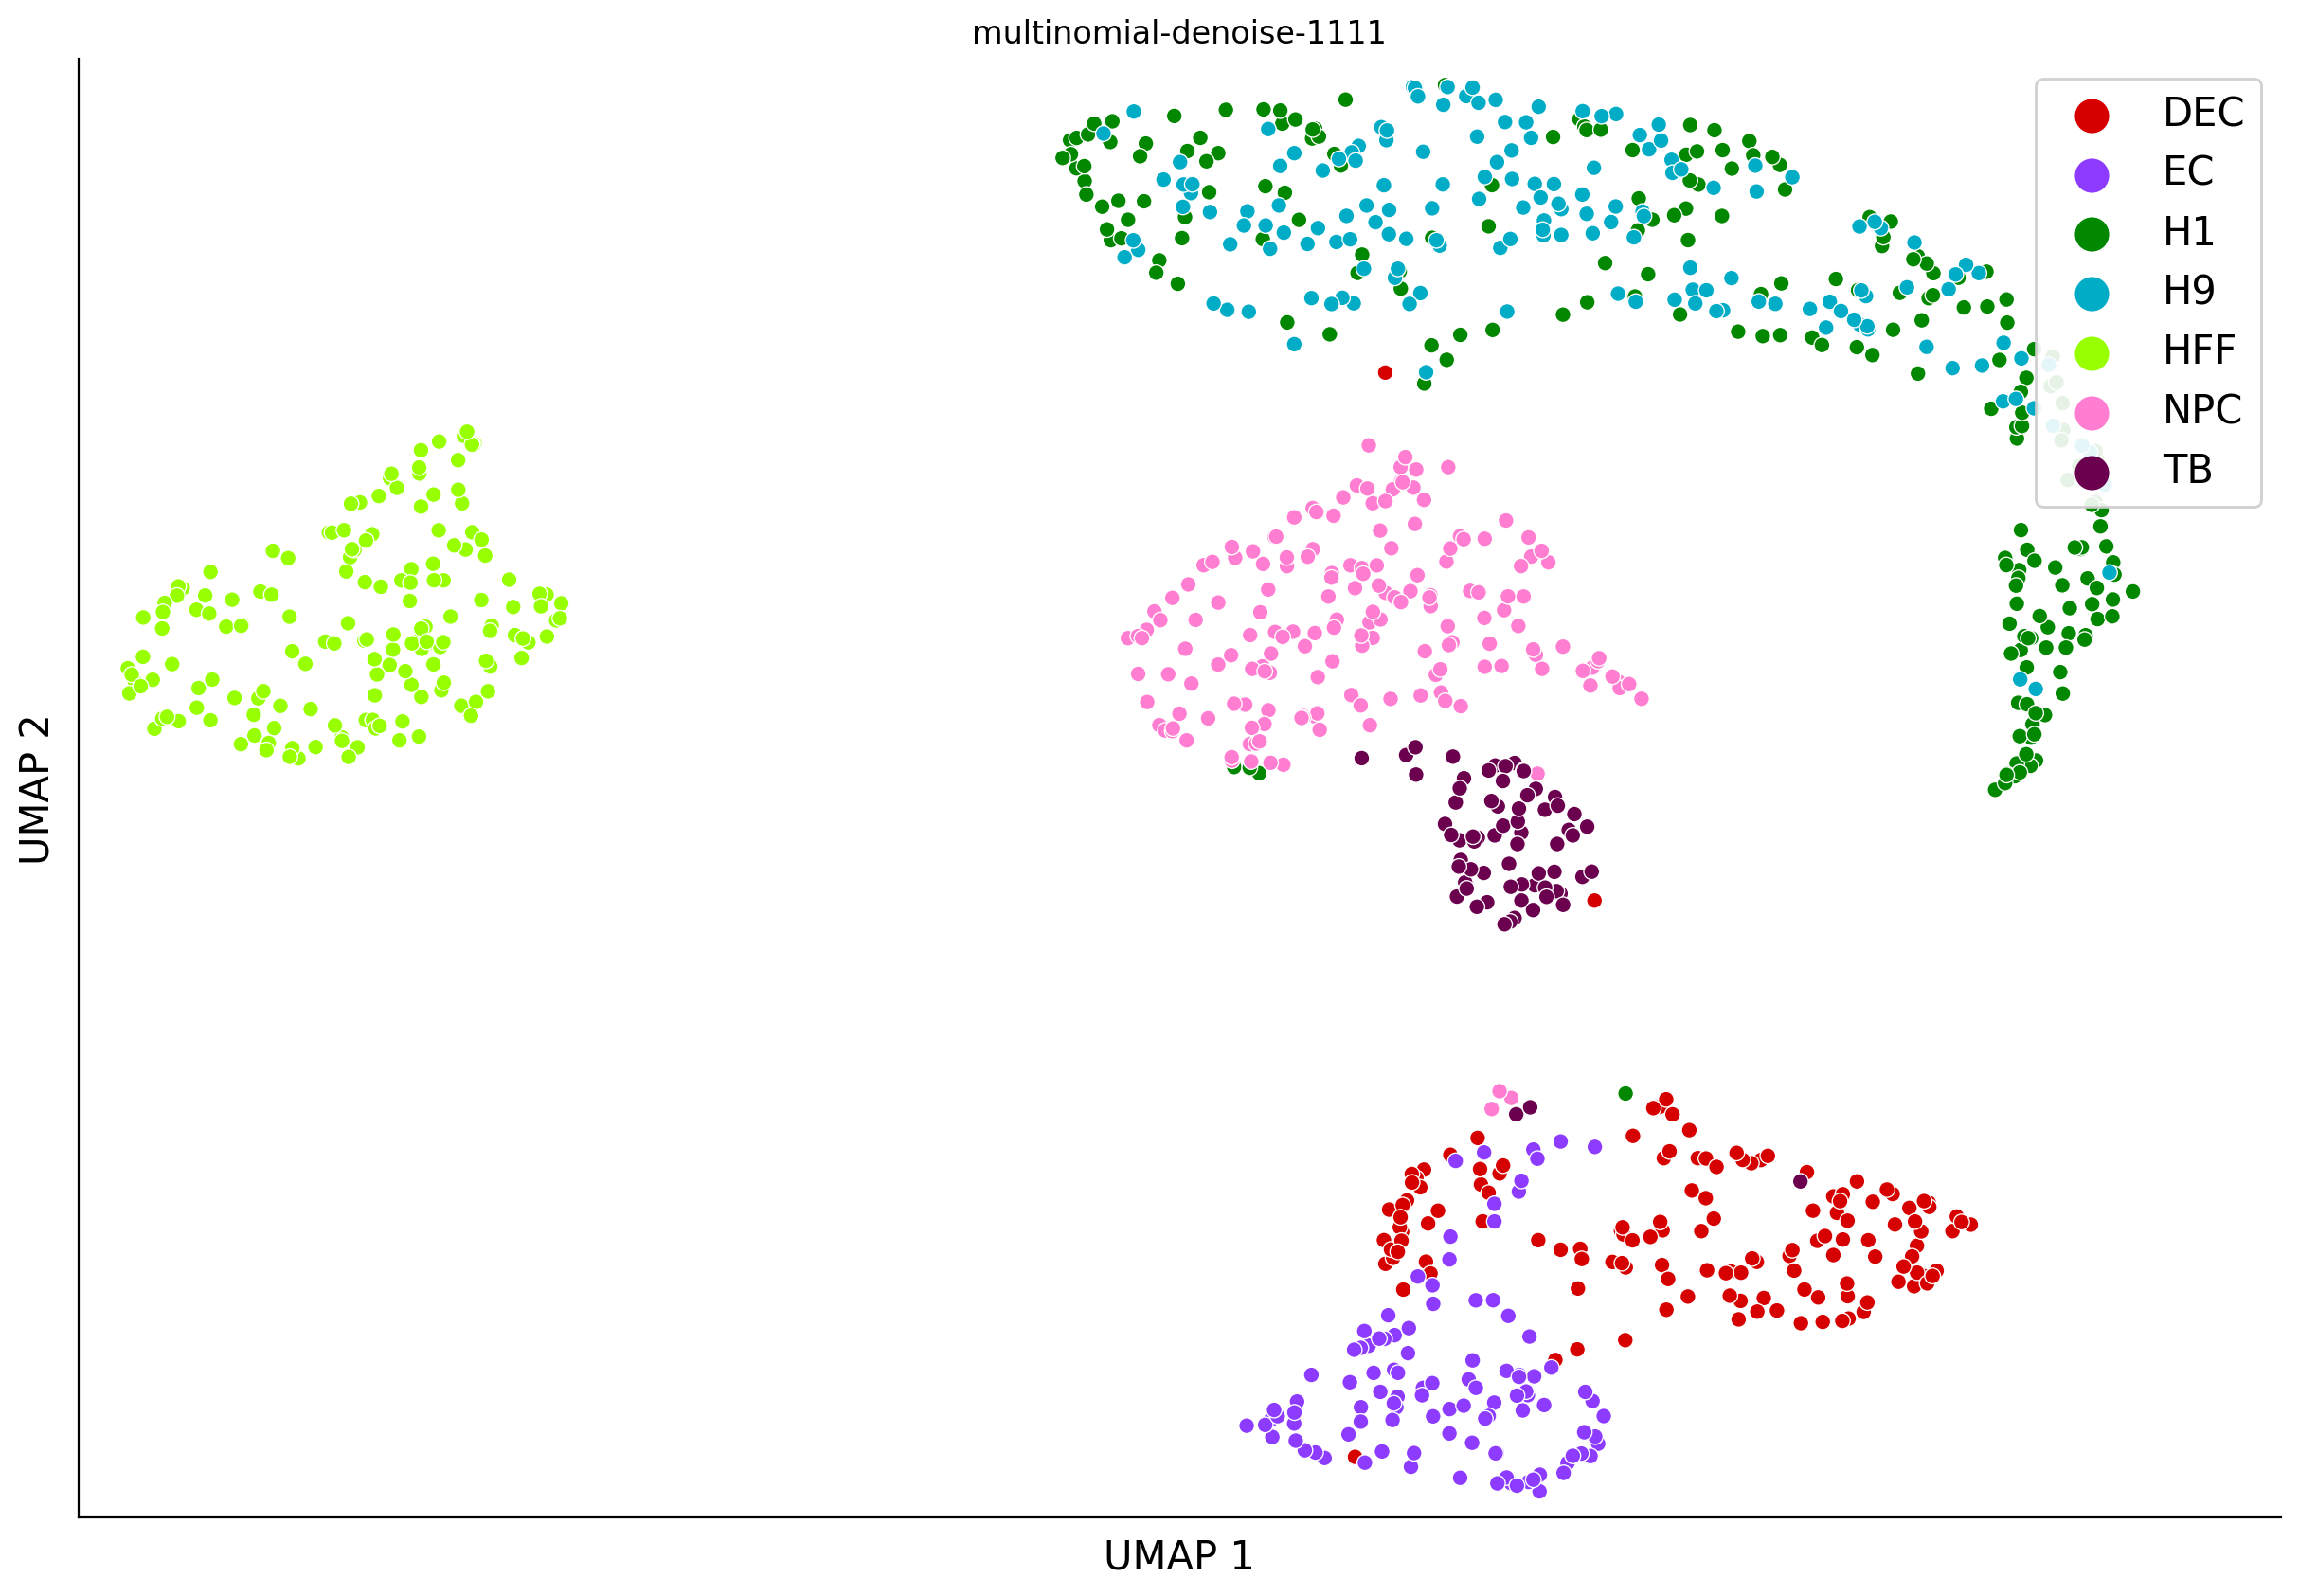

In [238]:
# zinb
zinb.get_umap(labelsize=15)

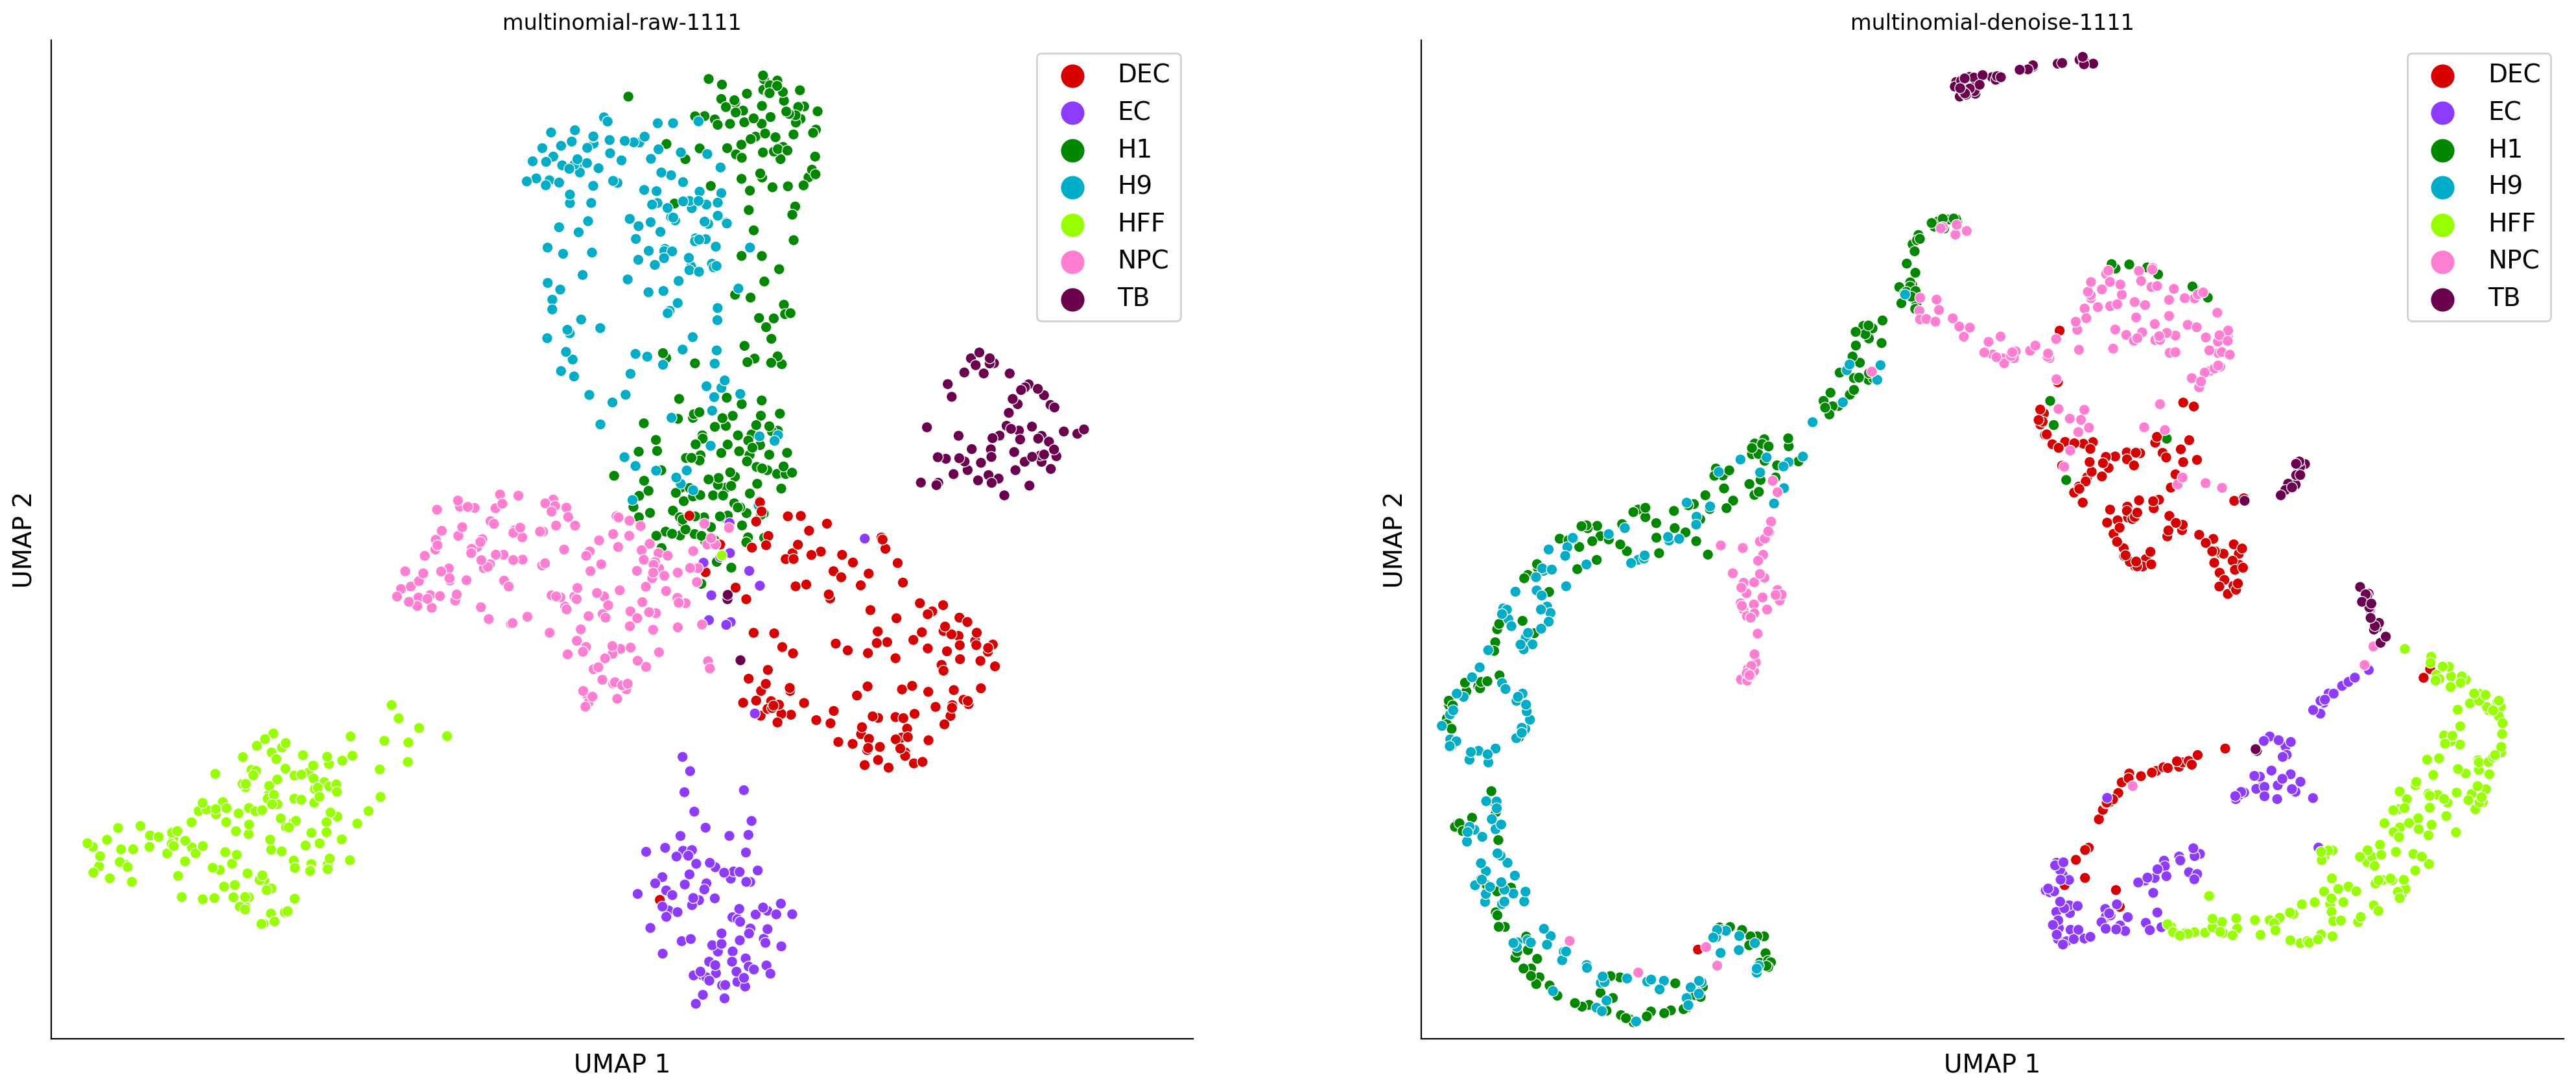

In [212]:
#weight mse
wmse.get_umap(same_figure=True)

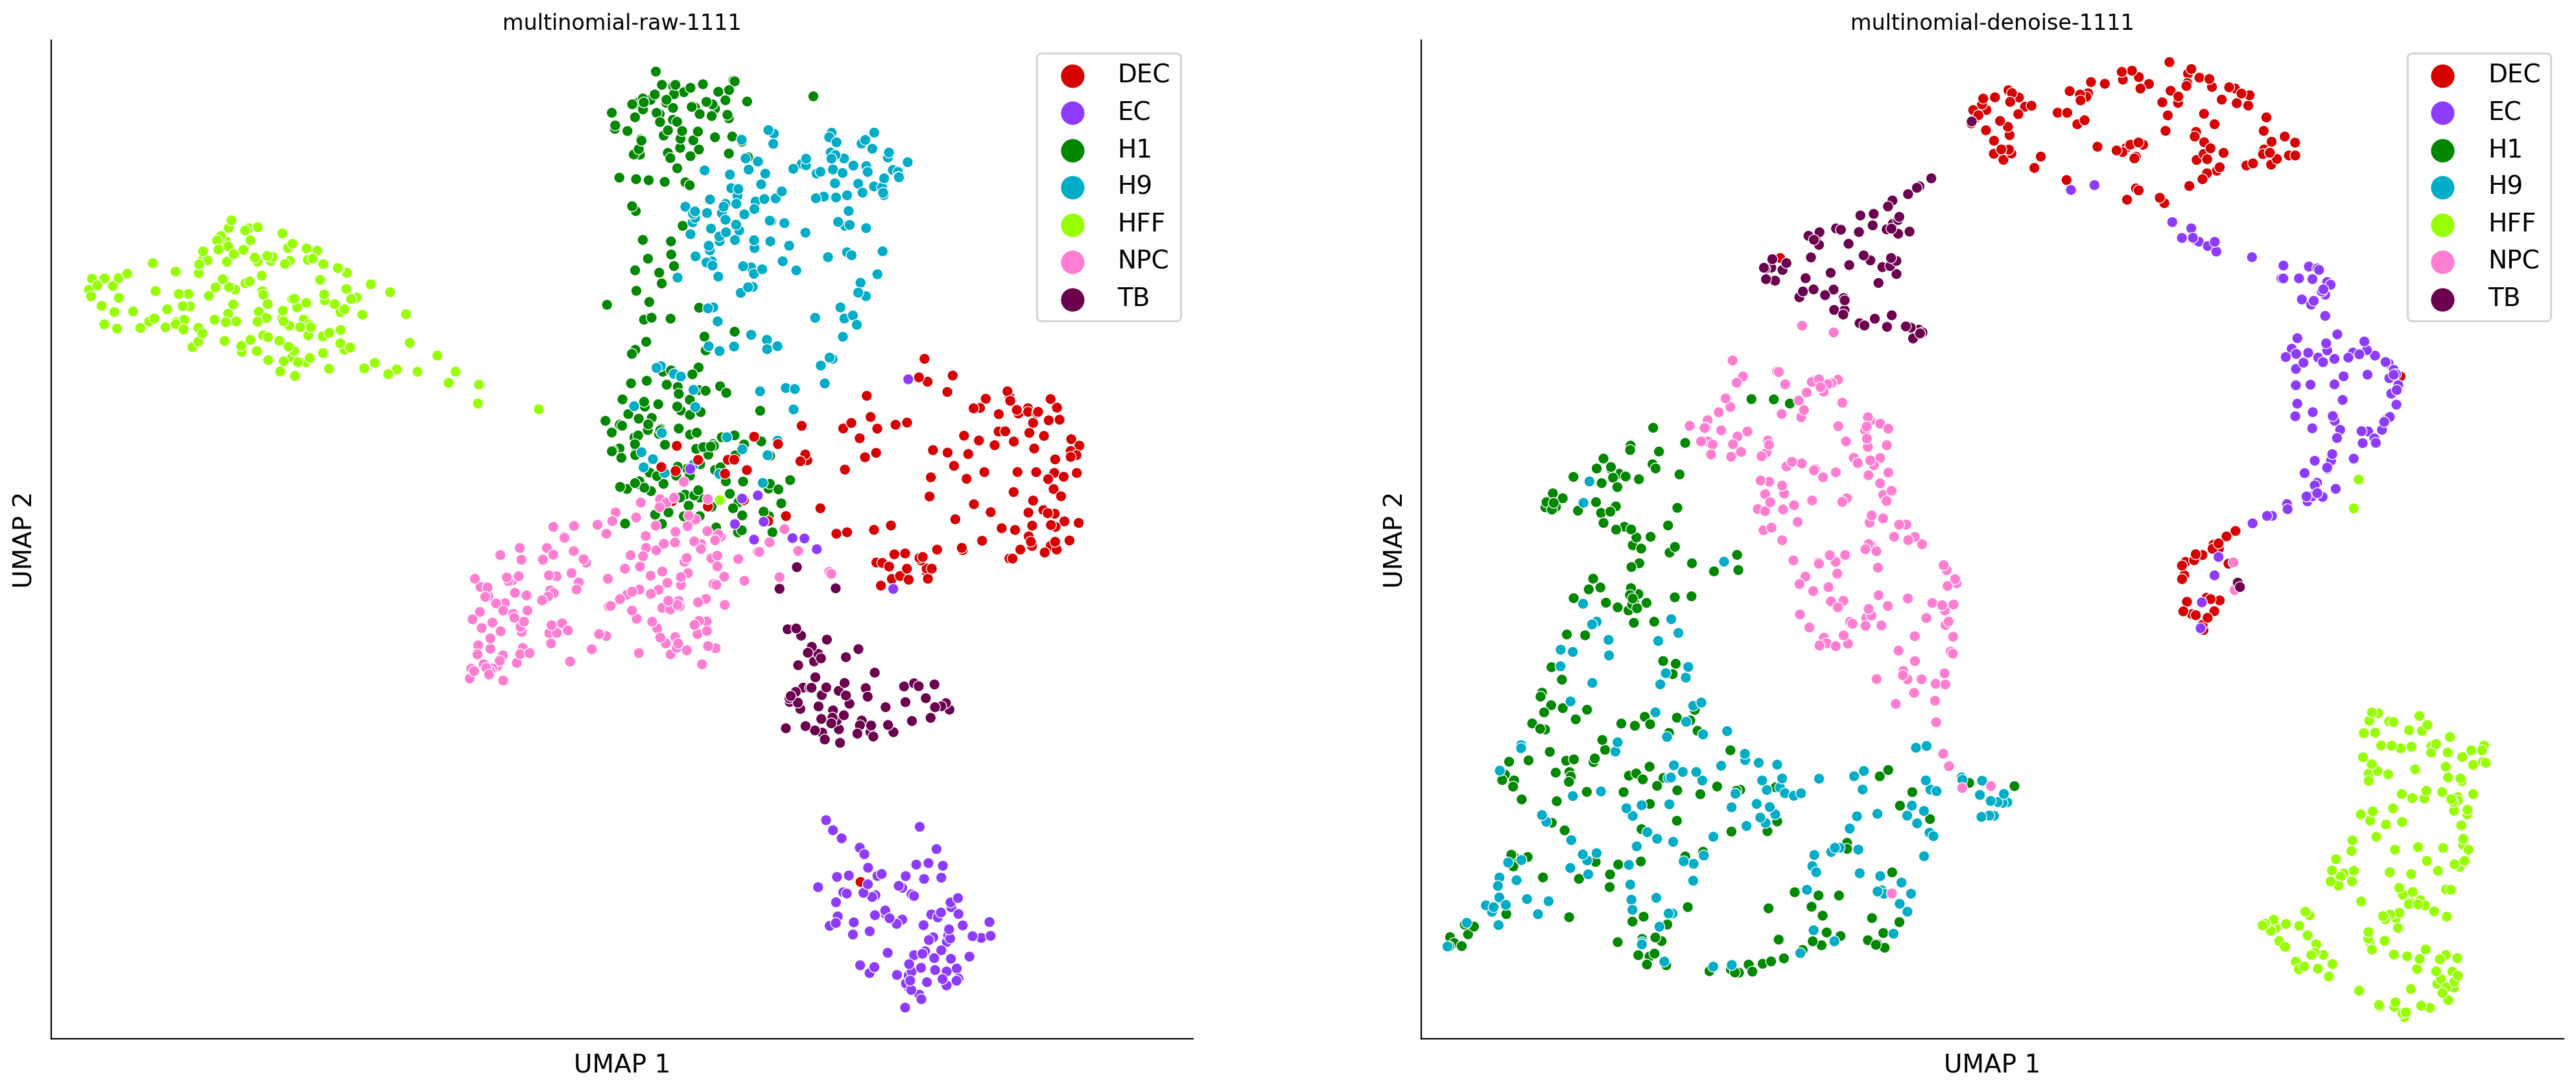

In [216]:
mmse.get_umap(same_figure=True)

## Simulated data

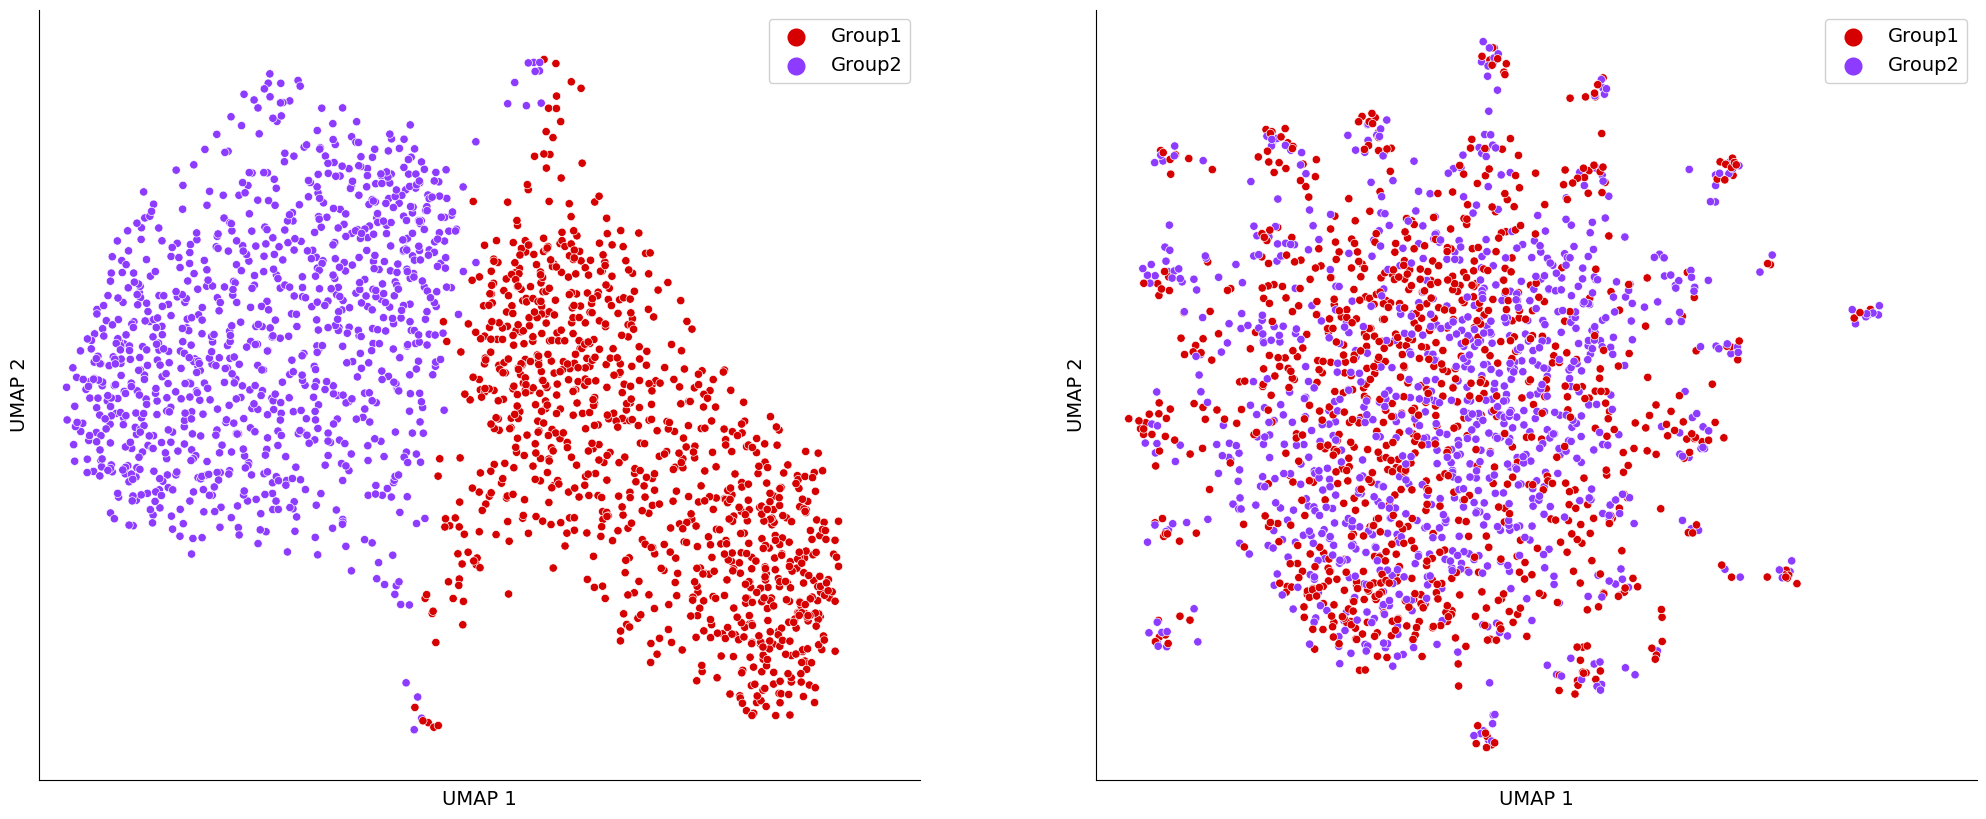

In [77]:
from scDMFK.io import calculate_cluster_results, draw_umap, draw_multiple_umap

data = 'group2_dropout5'
# true data
sim_true = pd.read_csv('data/' + data + '/info_truecounts.tsv', sep='\t',index_col=0).T
sim_raw = pd.read_csv('data/' + data + '/counts.tsv', sep='\t',index_col=0).T

# true labels
sim_label= pd.read_csv('data/'+ data + '/info_cellinfo.tsv', sep='\t')['Group']

# sim_ari, sim_nmi, sim_sc, sim_embed = calculate_cluster_results(sim_true, sim_label, seed=1111)
# _, _,_, sim_raw_embed = calculate_cluster_results(sim_raw, sim_label, seed=1111)
draw_multiple_umap(embeddings=[sim_embed, sim_raw_embed], label=sim_label)


In [207]:
## simulated data
denoise_method = 'multinomial' # 'zinb', 'weight mse', 'mask mse'
mode = ['raw', 'denoise', 'latent']

sim_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')

multinom = Clustering(adata=sim_multinom, dataname=data, denoise_method=denoise_method, 
                    label=sim_label, random_seed=1111, mode=['raw','denoise','latent'])
multinom.get_output()

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: -0.00013905687635389966
Normalized Mutual Information: 0.00025560735899150317
Silhouette Coefficient: 0.34878966212272644
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: -0.0004513701264184015
Normalized Mutual Information: 2.041372474599505e-05
Silhouette Coefficient: 0.4076411724090576
seed: 1111  Evaluating clustering results for latent data...
Adjusted Rand Index: 0.00028414819441866727
Normalized Mutual Information: 0.0005505268941158129
Silhouette Coefficient: 0.5156005024909973


data denoise method  ...                     NMI          SC
0  group2_dropout5    multinomial  ...  0.00025560735899150317  0.34878966
1  group2_dropout5    multinomial  ...   2.041372474599505e-05  0.40764117
2  group2_dropout5    multinomial  ...   0.0005505268941158129   0.5156005

[3 rows x 7 columns]

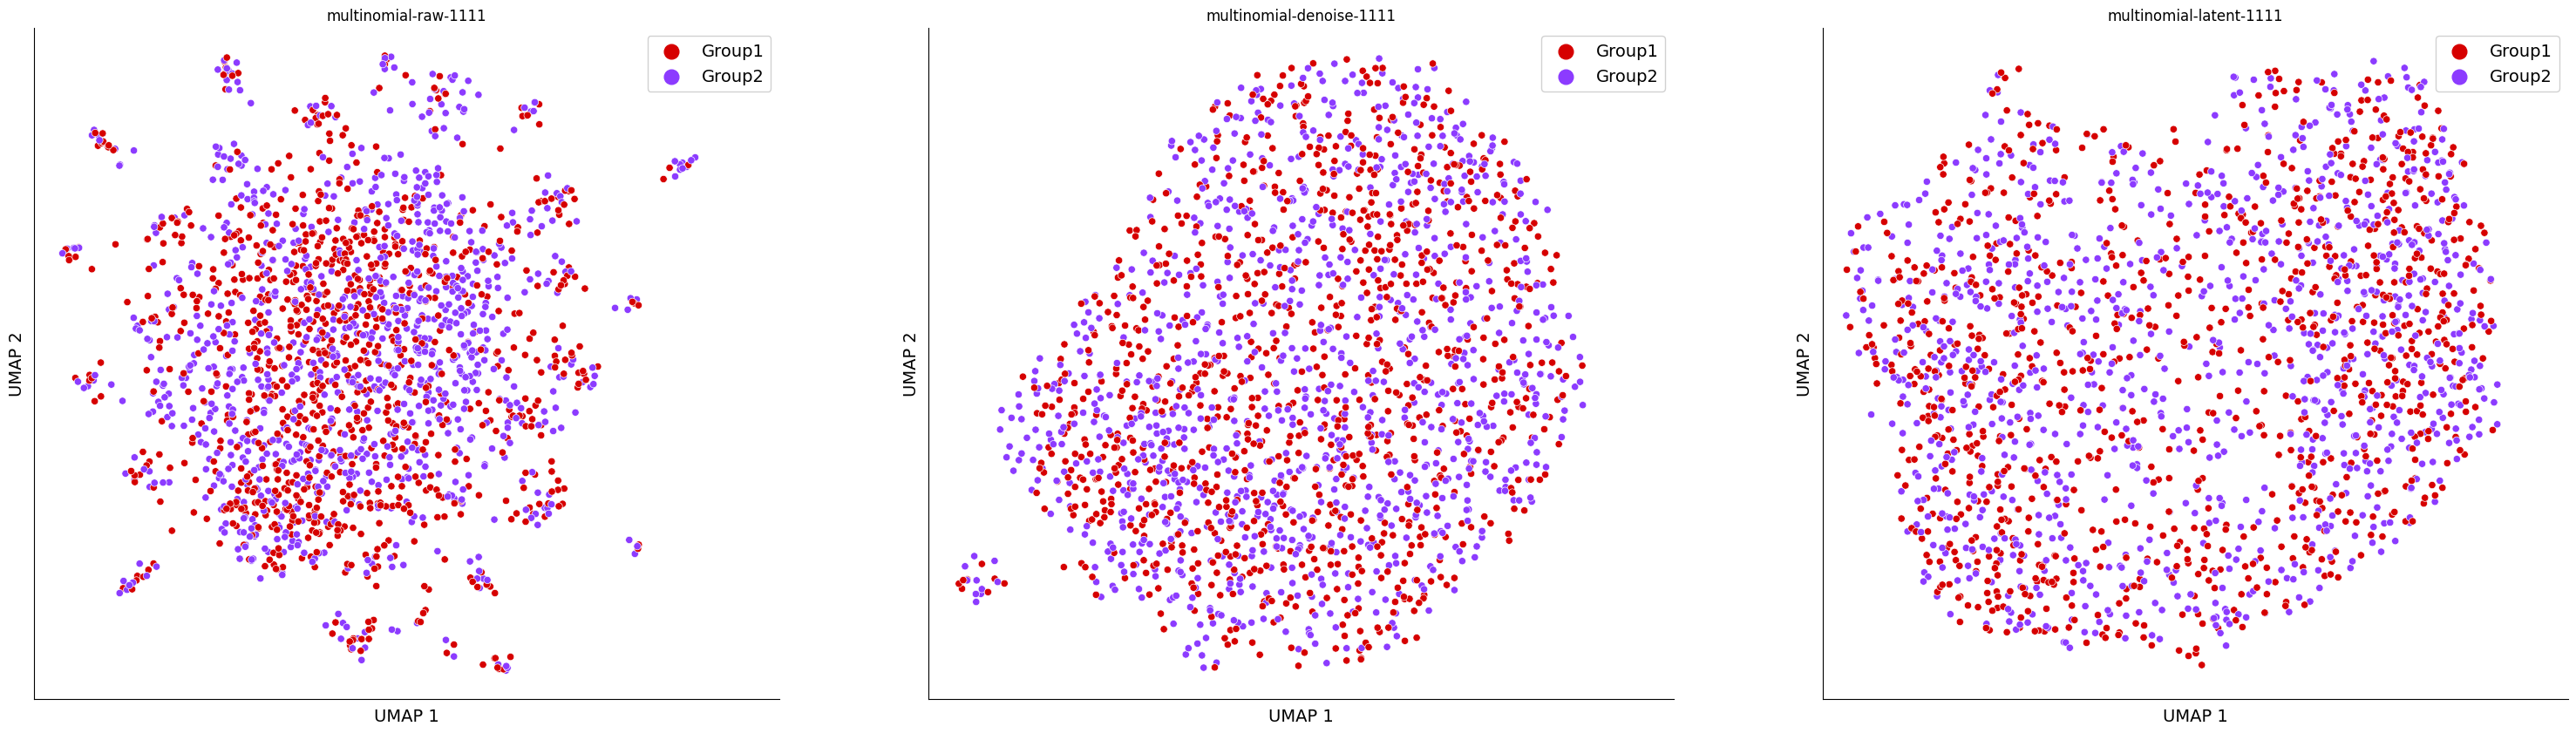

In [208]:
multinom.get_umap(same_figure=True)

In [58]:
import anndata
## simulated data
denoise_method = 'dca' #'multinomial', 'zinb', 'weight mse', 'mask mse'
mode = ['raw', 'denoise']

# data = 'group2_dropout5'
# sim_raw = sc.read_csv('data/' + data + '/counts.tsv', '\t').T
# sim_dca = sc.read_csv('results/' + data + '/mean.tsv', '\t').T
# sim_dca.raw = sim_raw
# sim_dca
# # true labels
sim_label= pd.read_csv('data/'+ data + '/info_cellinfo.tsv', sep='\t')['Group']

dca = Clustering(adata=sim_dca, dataname=data, denoise_method=denoise_method, 
                    label=sim_label, random_seed=1111, mode=['raw','denoise'])
dca.get_output()

seed: 1111  Evaluating clustering results for raw data...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Adjusted Rand Index: -0.00047522309740089165
Normalized Mutual Information: 1.8046751819875046e-05
Silhouette Coefficient: 0.35051238536834717
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: -0.0004913096342093474
Normalized Mutual Information: 1.2756523842633551e-05
Silhouette Coefficient: 0.4370364248752594


data denoise method     mode random seed  \
0  group2_dropout5            dca      raw        1111   
1  group2_dropout5            dca  denoise        1111   

                       ARI                     NMI          SC  
0  -0.00047522309740089165  1.8046751819875046e-05   0.3505124  
1   -0.0004913096342093474  1.2756523842633551e-05  0.43703642

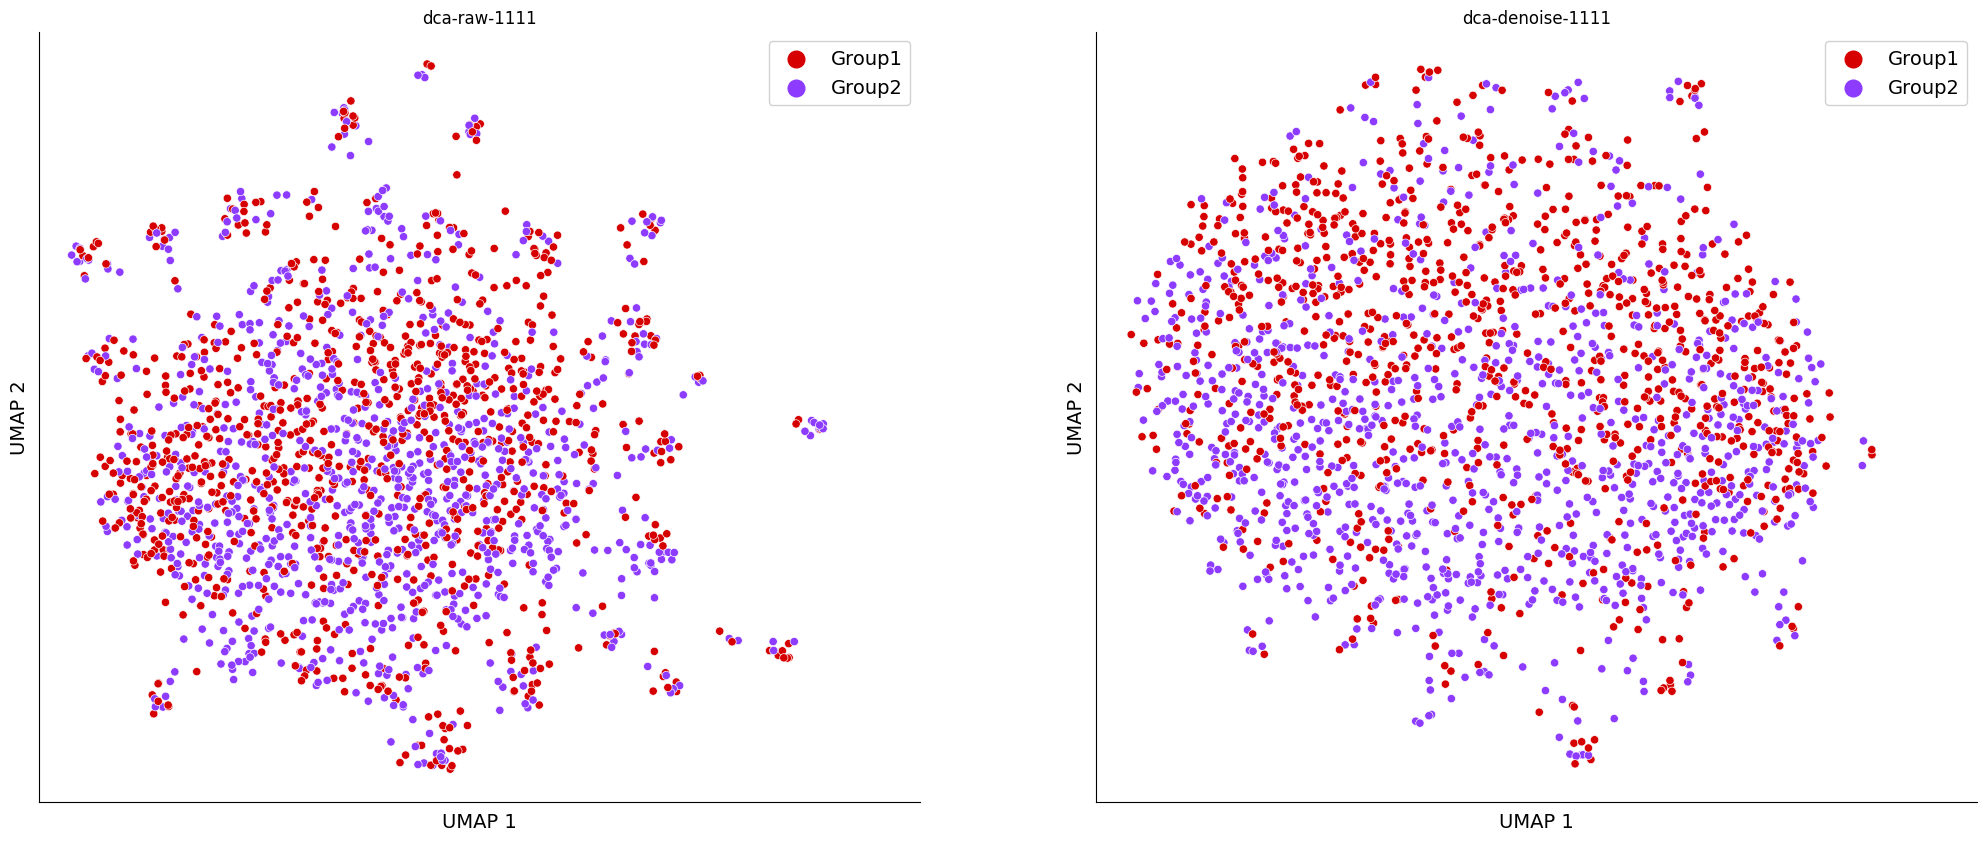

In [60]:
dca.get_umap(same_figure=True)

## Correlation Anlysis & Differentially Expressed Genes

In [247]:
import anndata as ad

sc.settings.set_figure_params(dpi=100, facecolor="white")

In [295]:
from scDMFK.preprocess import *

In [296]:
end_multinom.obs['Group'] = end_label.values
end_raw = prepro('endoderm/endoderm.csv', transpose=True)
end_raw.obs['Group'] = end_label.values
end_raw

Successfully preprocessed 19097 genes and 1018 cells


AnnData object with n_obs × n_vars = 1018 × 19097
    obs: 'Group'
    var: 'Group'

#### highly expressed gene selection

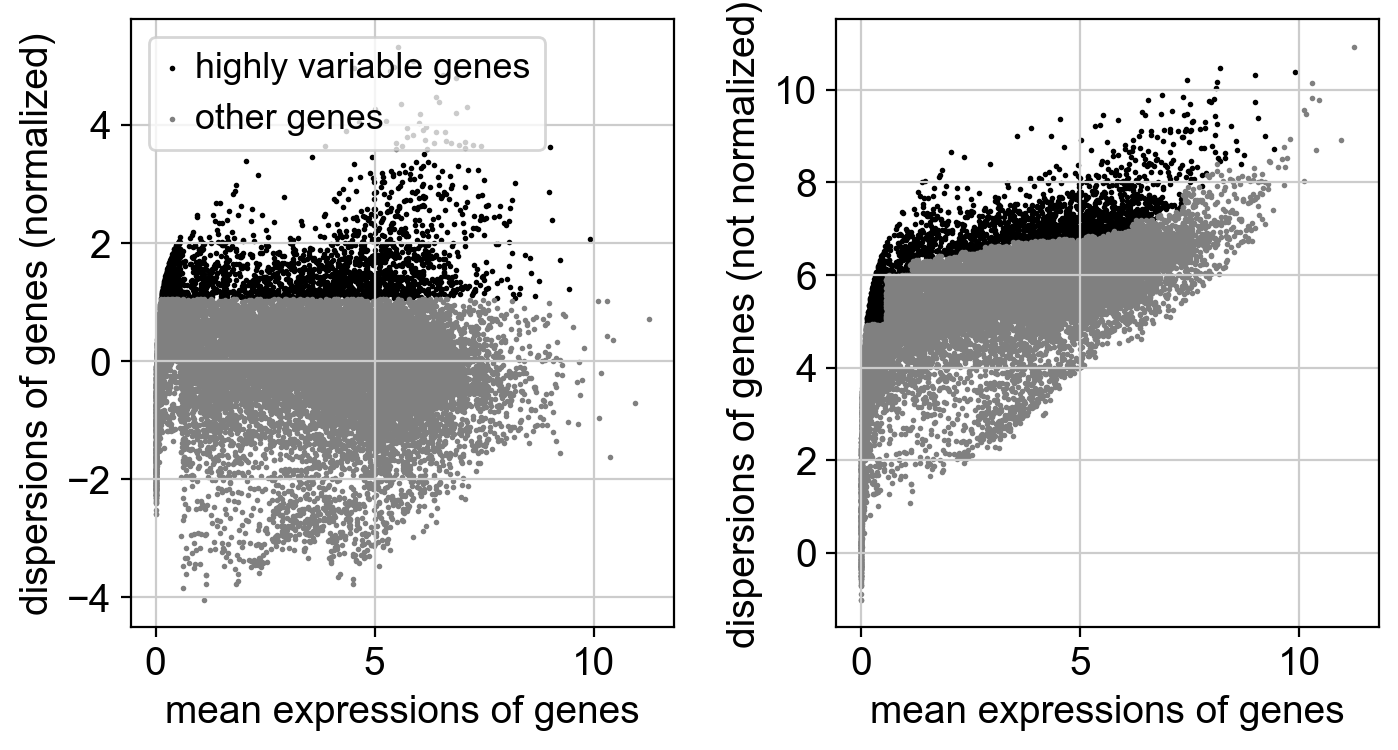

In [298]:
# Saving count data
end_raw.layers["counts"] = end_raw.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(end_raw)
# Logarithmize the data
sc.pp.log1p(end_raw)

sc.pp.highly_variable_genes(end_raw, n_top_genes=2000)
sc.pl.highly_variable_genes(end_raw)

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


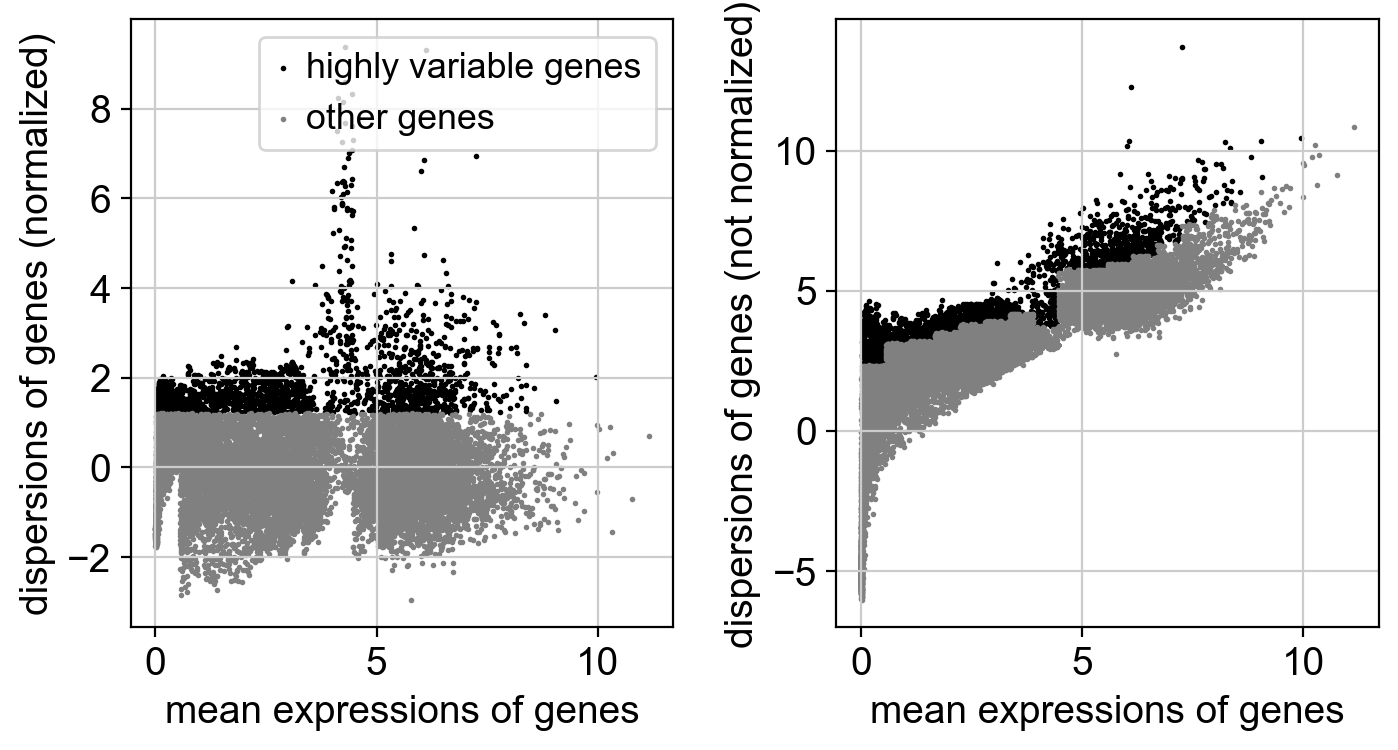

In [261]:
# Saving count data
end_multinom.layers["counts"] = end_multinom.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(end_multinom)
# Logarithmize the data
sc.pp.log1p(end_multinom)
sc.pp.highly_variable_genes(end_multinom, n_top_genes=2000)
sc.pl.highly_variable_genes(end_multinom)

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Group'}, xlabel='UMAP1', ylabel='UMAP2'>

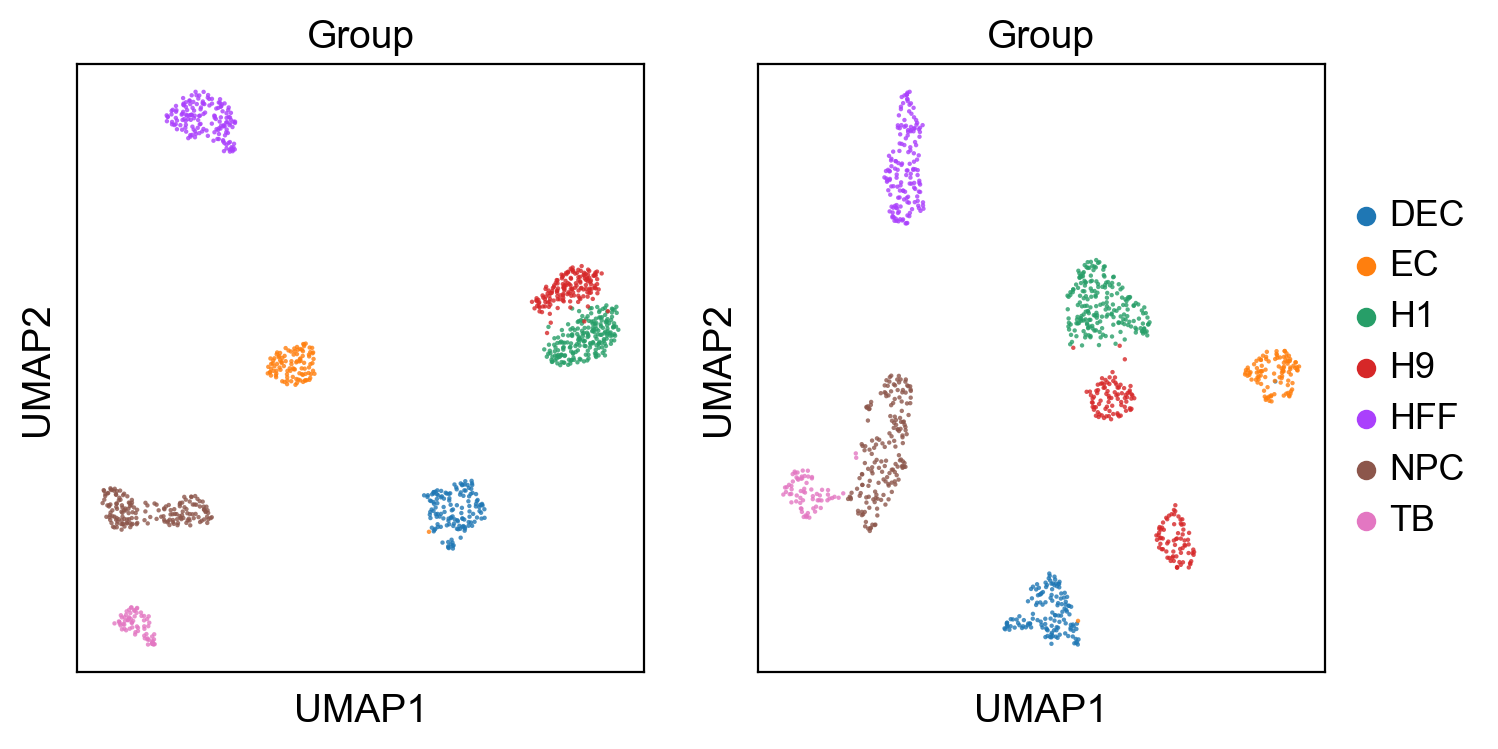

In [313]:
# sc.pp.pca(end_multinom)
# sc.pp.pca(end_raw)
sc.pp.neighbors(end_multinom)
sc.pp.neighbors(end_raw)

sc.tl.umap(end_multinom)
sc.tl.umap(end_raw)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
# sc.pl.pca_scatter(end_raw, color=['Group'],size=10,alpha=0.8, ax=ax1, show=False, legend_loc=None)
# sc.pl.pca_scatter(end_multinom, color=['Group'],size=10,alpha=0.8, ax=ax2, show=False)
sc.pl.umap(end_raw, color=['Group'],size=10,alpha=0.8, ax=ax1, show=False, legend_loc=None)
sc.pl.umap(end_multinom, color=['Group'],size=10,alpha=0.8, ax=ax2, show=False)

In [311]:
sc.tl.leiden(end_multinom, flavor="igraph", n_iterations=2)
sc.pl.umap(end_multinom, color=["leiden"])


ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

In [314]:
### Differentially expressed genes
sc.tl.rank_genes_groups(end_multinom, groupby="leiden_res_0.50", method="wilcoxon")
# sc.pl.rank_genes_groups_dotplot(
#     sc.tl.rank_genes_groups(end_multinom, groupby="leiden_res_0.50", method="wilcoxon")
# , groupby="leiden_res_0.50", standard_scale="var", n_genes=5
# )

KeyError: 'leiden_res_0.50'